In [ ]:
# Business Case/ Auto Loan Credit Decisioning Model 

In [562]:
# Import different libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost  as xgb
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer 
from scipy import stats

In [563]:
# Import the training dataset 
training= pd.read_csv('Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv')
training.head()
# Target_variable = 'bad_flag' ; Remaining 42 features are predictors

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  581.0          0           32115.0                              NEW   
1  707.0          1           21436.0                             USED   
2  689.0          0           26930.0                             USED   
3  811.0          1           18140.0                             USED   
4  631.0          0            9874.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0     15.29    105.30           72.0           72.0            3.0   
1      4.63    102.12          100.0           84.0            0.0   
2      6.61    109.24           76.0           13.0            0.0   
3      3.08     49.03           12.0           12.0            0.0   
4      2.62    140.56            NaN            NaN            0.0   

   p12_aut7110_a  ...  clntr9437_a  clact9429_a  clall5010_a  clall2434_a  \
0           84.0  ...          NaN          NaN          NaN          NaN   
1            NaN  ...          NaN          NaN          NaN          NaN   
2            NaN  ...          NaN          NaN          NaN          NaN   
3           34.0  ...          NaN          NaN          NaN          NaN   
4            NaN  ...          7.0         21.0          NaN          NaN   

   cloil0214_a  cltra4405_a  clact9428_a  bad_flag     Gender   Race  
0          NaN          NaN          NaN       0.0     Female  White  
1          NaN          NaN          NaN       0.0       Male  White  
2          NaN          NaN          NaN       0.0  Undefined  White  
3          NaN          NaN          NaN       0.0     Female  Other  
4          NaN          NaN          5.0       0.0       Male  White  

[5 rows x 43 columns]

In [564]:
# Import the testing dataset - Named as validation dataset
val_data = pd.read_csv('Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv')
val_data.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  681.0          1           30966.0                             USED   
1  626.0          0           18363.0                             USED   
2  776.0          1           50768.0                              NEW   
3  721.0          1           49657.0                              NEW   
4    NaN          0           14412.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0      4.74     91.96           85.0           70.0            0.0   
1      3.37     87.90            NaN            NaN            0.0   
2      3.86    107.87           22.0           18.0            0.0   
3      3.71     99.36           93.0           83.0            0.0   
4      7.94    111.50           42.0           20.0            0.0   

   p12_aut7110_a  ...  clntr9437_a  clact9429_a  clall5010_a  clall2434_a  \
0            NaN  ...          NaN          NaN          NaN          NaN   
1           85.0  ...          3.0          3.0          NaN          NaN   
2           83.0  ...          NaN          NaN          NaN          NaN   
3           61.0  ...          NaN          NaN          NaN          NaN   
4            NaN  ...          NaN          NaN          NaN          NaN   

   cloil0214_a  cltra4405_a  clact9428_a  bad_flag     Gender      Race  
0          NaN          NaN          NaN       0.0  Undefined     White  
1          NaN          NaN          0.0       0.0     Female     White  
2          NaN          NaN          NaN       0.0     Female  Hispanic  
3          NaN          NaN          NaN       0.0       Male     White  
4          NaN          NaN          NaN       0.0     Female     White  

[5 rows x 43 columns]

In [565]:
val_data.shape # Test data has 5400 rows and 43 number of features 

(5400, 43)

In [566]:
training.shape # The training dataset has 21606 rows and 43 columns 

(21606, 43)

In [567]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21606 entries, 0 to 21605
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fico                              21431 non-null  float64
 1   aprv_flag                         21606 non-null  int64  
 2   amtfinanced_1req                  21606 non-null  float64
 3   collateral_dlrinput_newused_1req  21606 non-null  object 
 4   pti_1req                          21603 non-null  float64
 5   ltv_1req                          21601 non-null  float64
 6   p12_reh7120_a                     19694 non-null  float64
 7   p12_bcx7110_a                     17917 non-null  float64
 8   p12_all7170_a                     20943 non-null  float64
 9   p12_aut7110_a                     11070 non-null  float64
 10  p12_all7120_a                     21226 non-null  float64
 11  p12_all7937_a                     21522 non-null  float64
 12  p12_

In [568]:
# From above ; There are 34 float variables, 6 integer variables/features and 3 categorical features 
# We will have to encode the categorical features to numerical features 

In [569]:
training.describe().round(2) # Descriptive statistics to check mean, min, max, std deviation 

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  \
count  21431.00   21606.00          21606.00  21603.00  21601.00   
mean     703.64       0.74          29870.87      9.02    101.19   
std       82.79       0.44          15311.30      4.80     23.25   
min      372.00       0.00              0.00      0.08     10.35   
25%      644.00       0.00          19370.00      5.93     90.52   
50%      701.00       1.00          26806.00      8.59    103.47   
75%      766.00       1.00          36931.25     11.58    113.80   
max      894.00       1.00         189729.00    207.09    955.26   

       p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  \
count       19694.00       17917.00       20943.00       11070.00   
mean           51.87          35.86           3.60          66.26   
std            37.35          33.23          14.89          24.47   
min             0.00           0.00           0.00           0.00   
25%            16.00           6.00           0.00          50.00   
50%            52.00          26.00           0.00          72.00   
75%            88.00          63.00           0.00          86.00   
max           415.00         290.00         100.00         152.00   

       p12_all7120_a  ...  p12_alm6200_a  p12_all6971_a  clntr9437_a  \
count       21226.00  ...       21606.00       21562.00      8952.00   
mean           85.35  ...         149.76          58.45         1.39   
std            37.63  ...         181.35         133.39         3.43   
min             0.00  ...           1.00           0.00         0.00   
25%            73.00  ...           1.00           1.00         0.00   
50%            94.00  ...          30.00           1.00         0.00   
75%           100.00  ...         400.00           1.00         1.00   
max           711.00  ...         400.00         400.00        73.00   

       clact9429_a  clall5010_a  clall2434_a  cloil0214_a  cltra4405_a  \
count      8952.00      2390.00       719.00        78.00       787.00   
mean          2.26      2427.66         0.02         0.22         0.02   
std           6.93      4421.54         0.14         0.42         0.22   
min           0.00         0.00         0.00         0.00         0.00   
25%           0.00         0.00         0.00         0.00         0.00   
50%           0.00         0.00         0.00         0.00         0.00   
75%           2.00      2798.25         0.00         0.00         0.00   
max         178.00     33549.00         1.00         1.00         3.00   

       clact9428_a  bad_flag  
count      8952.00  21348.00  
mean          0.61      0.04  
std           2.29      0.21  
min           0.00      0.00  
25%           0.00      0.00  
50%           0.00      0.00  
75%           0.00      0.00  
max          69.00      1.00  

[8 rows x 40 columns]

In [570]:
# Check the number of unique values in each of categorical features 
training['collateral_dlrinput_newused_1req'].unique() # There are two types of collateral vehicle - 'New' and 'Used'

array(['NEW', 'USED'], dtype=object)

In [571]:
# The unique values in Gender
training['Gender'].unique() # There are two races - Male and Female and Some are undefined 

array(['Female', 'Male', 'Undefined'], dtype=object)

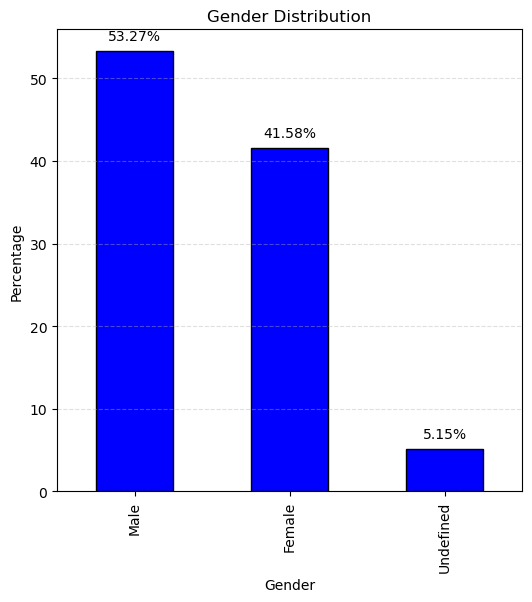

In [572]:
# Distribution of the gender as a percentage
gender_counts= training['Gender'].value_counts()
gender_percent = (gender_counts/gender_counts.sum())*100
plt.figure(figsize=(6,6))
gender_percent.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.grid(axis='y',linestyle= '--', alpha=0.4)

# Annotate each bar with number
for i, perc in enumerate(gender_percent):
    plt.text(i, perc+1, f'{perc:.2f}%', ha='center', va='bottom', fontsize=10) 
plt.savefig('Gender_Distribution')
plt.show()

In [573]:
# Unique values in Race 
training['Race'].unique() # There are a total of 5 races. 

array(['White', 'Other', 'Hispanic', 'Black', 'Asian'], dtype=object)

In [574]:
# Distribution of race 
race_counts= training['Race'].value_counts()
print(race_counts)

Race
White       11806
Hispanic     4864
Black        2941
Other        1441
Asian         554
Name: count, dtype: int64


In [575]:
# Percenatge of white and Non white 
white_percent = race_counts.get('White',0)/race_counts.sum()*100
#nonwhite_percent 
print(white_percent.round(2))

54.64


In [576]:
# Percentage of white and non_white 


In [577]:
# Check the missing values in each column 
missing_values = training.isnull().sum()
print(missing_values)  # None of the three categorical features have missing values. 

fico                                  175
aprv_flag                               0
amtfinanced_1req                        0
collateral_dlrinput_newused_1req        0
pti_1req                                3
ltv_1req                                5
p12_reh7120_a                        1912
p12_bcx7110_a                        3689
p12_all7170_a                         663
p12_aut7110_a                       10536
p12_all7120_a                         380
p12_all7937_a                          84
p12_bcc8120_a                        1854
p12_iln7410_a                        2242
p12_rev1300_a                         796
p12_all8150_a                       12399
p12_bca8370_a                        1585
p12_all7517_a                         344
p12_iln8220_a                        1930
p12_all6250_a                           0
p12_aua8151_a                       17814
p12_rtr7110_a                        9275
p12_pil8120_a                        9749
p12_aua0300_a                     

In [578]:
# Percentage of missing values in each column 
missing_percent = (training.isnull().sum()/len(training))*100
print(missing_percent.round(2))

fico                                 0.81
aprv_flag                            0.00
amtfinanced_1req                     0.00
collateral_dlrinput_newused_1req     0.00
pti_1req                             0.01
ltv_1req                             0.02
p12_reh7120_a                        8.85
p12_bcx7110_a                       17.07
p12_all7170_a                        3.07
p12_aut7110_a                       48.76
p12_all7120_a                        1.76
p12_all7937_a                        0.39
p12_bcc8120_a                        8.58
p12_iln7410_a                       10.38
p12_rev1300_a                        3.68
p12_all8150_a                       57.39
p12_bca8370_a                        7.34
p12_all7517_a                        1.59
p12_iln8220_a                        8.93
p12_all6250_a                        0.00
p12_aua8151_a                       82.45
p12_rtr7110_a                       42.93
p12_pil8120_a                       45.12
p12_aua0300_a                     

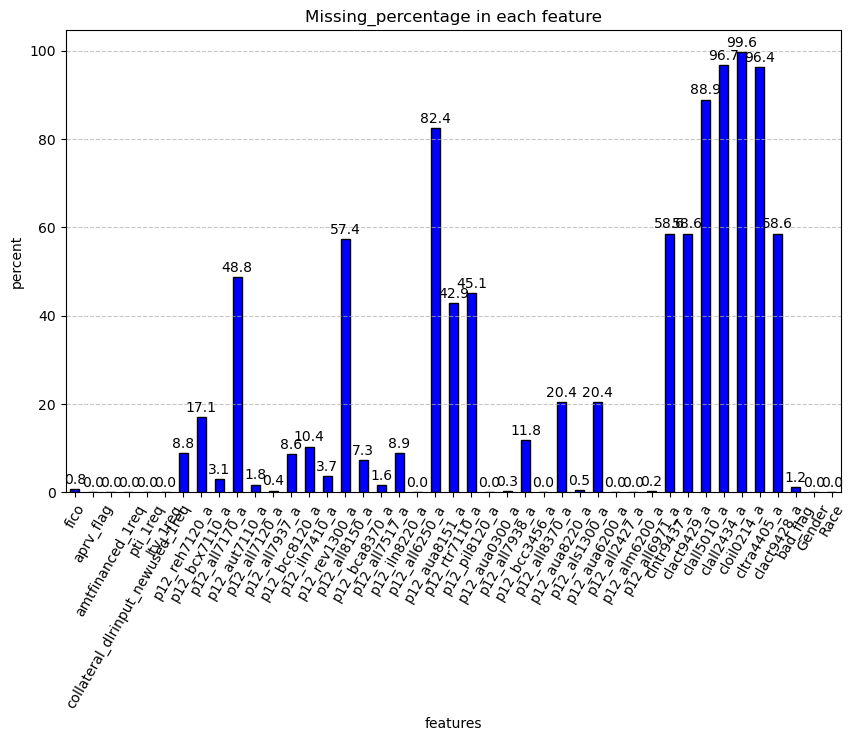

In [579]:
# Distribution of the NA values through bar plots 
plt.figure(figsize=(10,6))
missing_percent.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Missing_percentage in each feature')
plt.xlabel('features')
plt.ylabel('percent')
plt.xticks(rotation=60)
plt.grid(axis='y',linestyle= '--', alpha=0.7)

# Annotate each bar with percentage 
for i, v in enumerate(missing_percent):
    plt.text(i,v+0.5, f'{v:.1f}', ha='center', va='bottom', fontsize=10) 
plt.savefig('Distribution of missing values (Percentage)')
plt.show()

In [580]:
columns_highNA = missing_percent[missing_percent > 80].index.tolist()
print(columns_highNA)

['p12_aua8151_a', 'clall5010_a', 'clall2434_a', 'cloil0214_a', 'cltra4405_a']


In [581]:
# There are four features having missing values more then 80 percent. Drop those 4 features 
training1 = training.loc[:,missing_percent<=80]
training1.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  581.0          0           32115.0                              NEW   
1  707.0          1           21436.0                             USED   
2  689.0          0           26930.0                             USED   
3  811.0          1           18140.0                             USED   
4  631.0          0            9874.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0     15.29    105.30           72.0           72.0            3.0   
1      4.63    102.12          100.0           84.0            0.0   
2      6.61    109.24           76.0           13.0            0.0   
3      3.08     49.03           12.0           12.0            0.0   
4      2.62    140.56            NaN            NaN            0.0   

   p12_aut7110_a  ...  p12_aua6200_a  p12_all2427_a  p12_alm6200_a  \
0           84.0  ...            1.0              0            400   
1            NaN  ...            NaN              0              1   
2            NaN  ...            NaN              0             90   
3           34.0  ...            1.0              0              1   
4            NaN  ...          400.0              0            400   

   p12_all6971_a  clntr9437_a  clact9429_a  clact9428_a  bad_flag     Gender  \
0          400.0          NaN          NaN          NaN       0.0     Female   
1            1.0          NaN          NaN          NaN       0.0       Male   
2            1.0          NaN          NaN          NaN       0.0  Undefined   
3            1.0          NaN          NaN          NaN       0.0     Female   
4           90.0          7.0         21.0          5.0       0.0       Male   

    Race  
0  White  
1  White  
2  White  
3  Other  
4  White  

[5 rows x 38 columns]

In [582]:
#columns_highNA = na_percentage[na_percentage > 80].index.tolist()

NameError: name 'na_percentage' is not defined

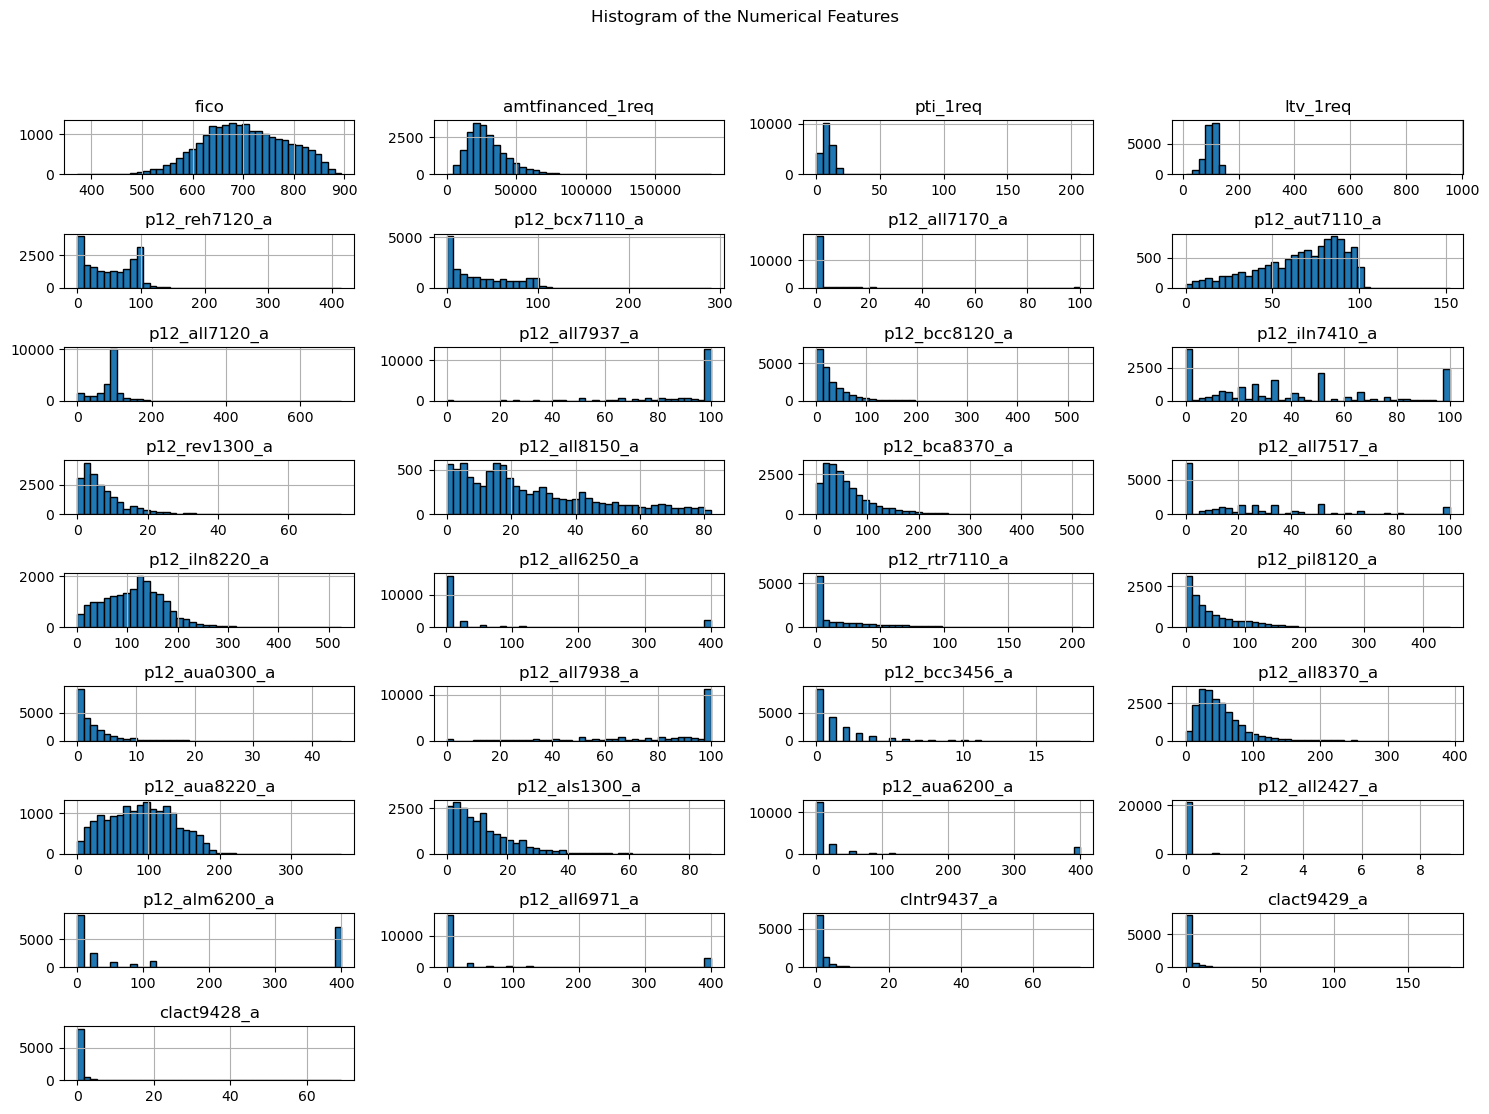

In [583]:
# Check the distribution of all numerical variables using Histogram Plot. Drop the categorical features 'aprv_flag' and 'bad_flag'
categ_columns = ['aprv_flag', 'bad_flag']
columns_plot = training1.drop(columns= categ_columns)
num_columns = columns_plot.select_dtypes(include='number').columns
columns_plot[num_columns].hist(bins=40, figsize = (15,15), layout= (len(num_columns)//3+1,4), edgecolor='black')
plt.suptitle('Histogram of the Numerical Features')
plt.tight_layout(rect = [0,0.03, 1,0.95])
plt.savefig('Histogram of Numerical Features')
plt.show()

In [86]:
# Missing Values Treatment 
# 1. Replace the missing values with mean 
# 2. Replace the missing values with median 
# 3. Replace the Normal Distributed features with mean and skewed distributions with median

In [584]:
# 1. Impute the missing values with mean 

# Initialize the imputer 
Imputer = SimpleImputer(strategy = 'mean')
training1.loc[:,training1.select_dtypes(include='number').columns] = Imputer.fit_transform(training1[training1.select_dtypes(include='number').columns])

In [585]:
# Verify if there are still NA values 
print(training1.isnull().sum())

fico                                0
aprv_flag                           0
amtfinanced_1req                    0
collateral_dlrinput_newused_1req    0
pti_1req                            0
ltv_1req                            0
p12_reh7120_a                       0
p12_bcx7110_a                       0
p12_all7170_a                       0
p12_aut7110_a                       0
p12_all7120_a                       0
p12_all7937_a                       0
p12_bcc8120_a                       0
p12_iln7410_a                       0
p12_rev1300_a                       0
p12_all8150_a                       0
p12_bca8370_a                       0
p12_all7517_a                       0
p12_iln8220_a                       0
p12_all6250_a                       0
p12_rtr7110_a                       0
p12_pil8120_a                       0
p12_aua0300_a                       0
p12_all7938_a                       0
p12_bcc3456_a                       0
p12_all8370_a                       0
p12_aua8220_

In [586]:
training1.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  581.0          0           32115.0                              NEW   
1  707.0          1           21436.0                             USED   
2  689.0          0           26930.0                             USED   
3  811.0          1           18140.0                             USED   
4  631.0          0            9874.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0     15.29    105.30      72.000000       72.00000            3.0   
1      4.63    102.12     100.000000       84.00000            0.0   
2      6.61    109.24      76.000000       13.00000            0.0   
3      3.08     49.03      12.000000       12.00000            0.0   
4      2.62    140.56      51.866406       35.86337            0.0   

   p12_aut7110_a  ...  p12_aua6200_a  p12_all2427_a  p12_alm6200_a  \
0      84.000000  ...       1.000000              0            400   
1      66.256459  ...      46.581424              0              1   
2      66.256459  ...      46.581424              0             90   
3      34.000000  ...       1.000000              0              1   
4      66.256459  ...     400.000000              0            400   

   p12_all6971_a  clntr9437_a  clact9429_a  clact9428_a  bad_flag     Gender  \
0          400.0     1.391309     2.264187     0.614946       0.0     Female   
1            1.0     1.391309     2.264187     0.614946       0.0       Male   
2            1.0     1.391309     2.264187     0.614946       0.0  Undefined   
3            1.0     1.391309     2.264187     0.614946       0.0     Female   
4           90.0     7.000000    21.000000     5.000000       0.0       Male   

    Race  
0  White  
1  White  
2  White  
3  Other  
4  White  

[5 rows x 38 columns]

C:\Users\sushant.tamu\AppData\Local\Temp\ipykernel_10856\2267635525.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,6))
C:\Users\sushant.tamu\AppData\Local\Temp\ipykernel_10856\2267635525.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=training1, x= predictor , hue= 'bad_flag', fill = True , alpha =0.3, palette = 'Set1')


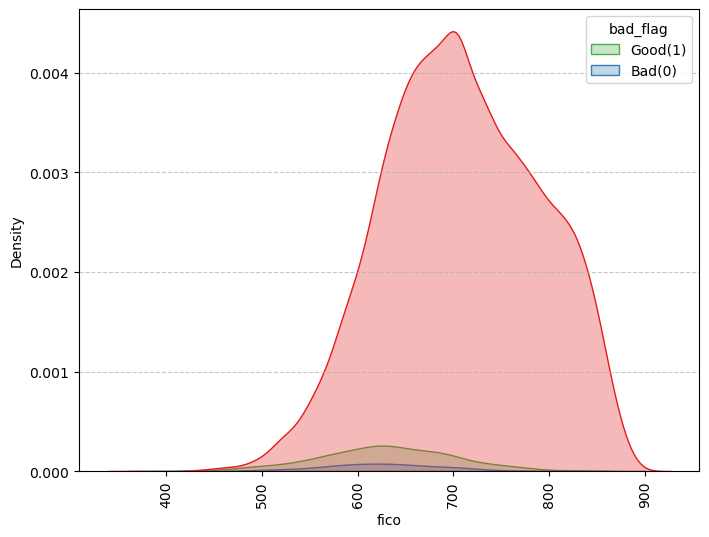

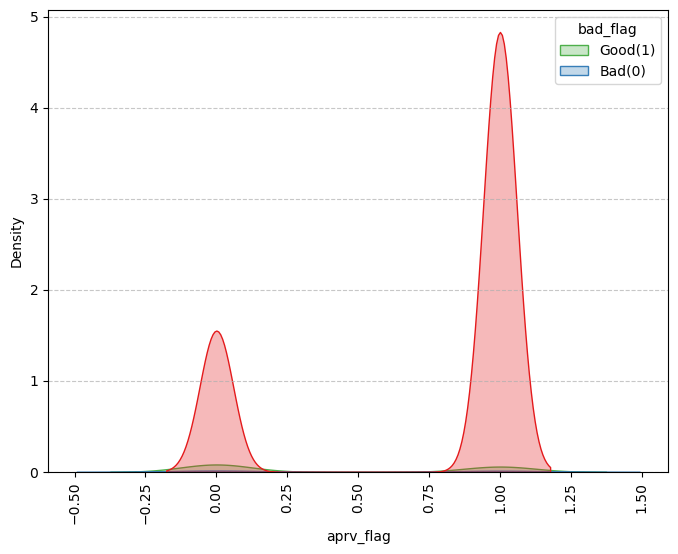

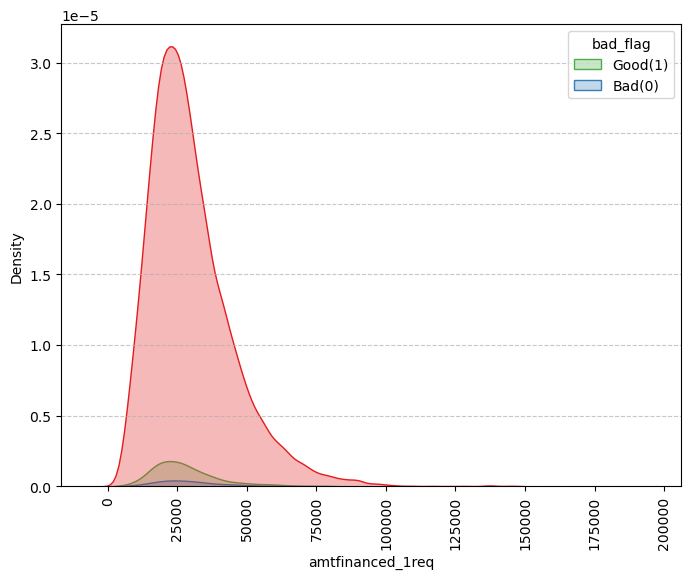

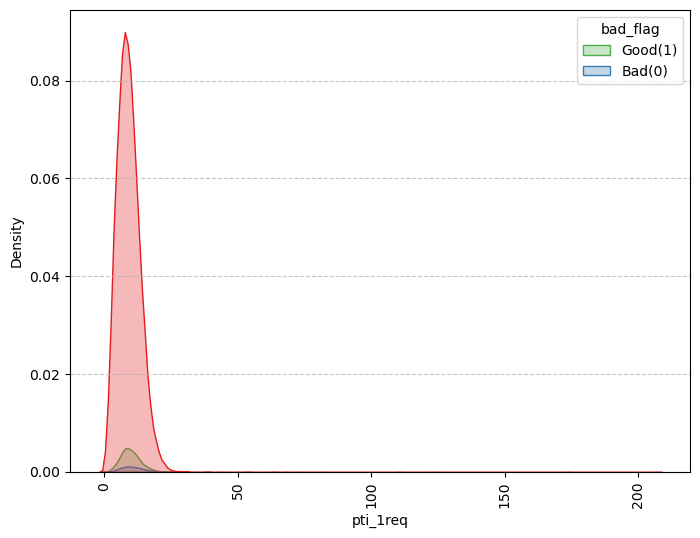

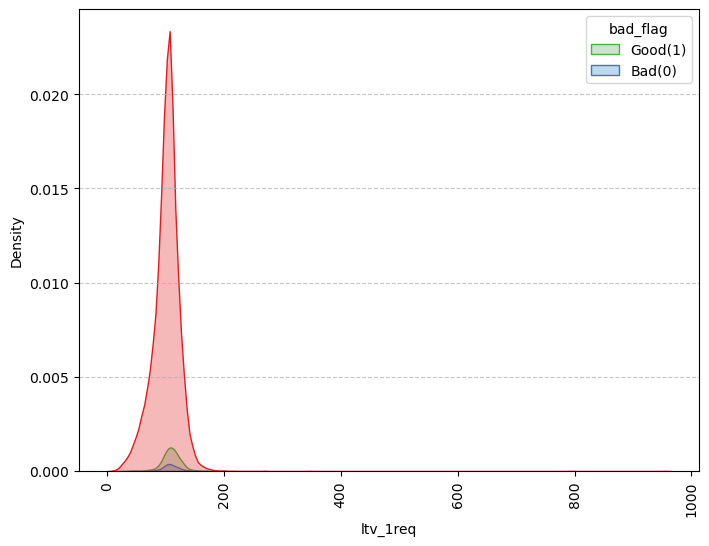

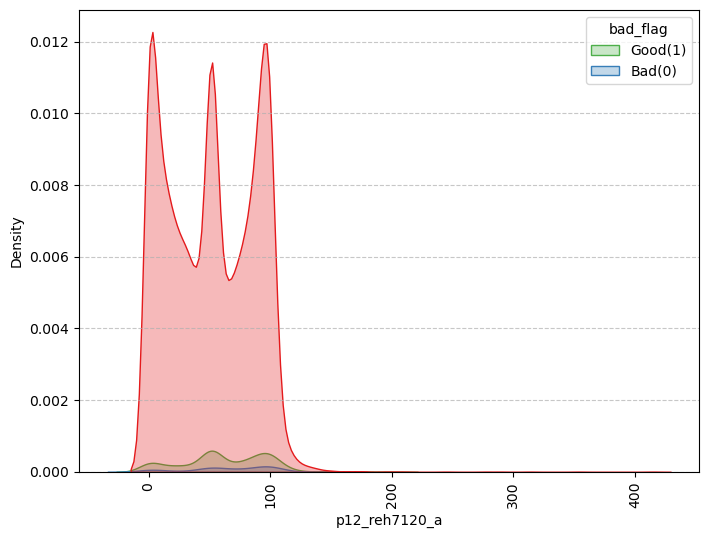

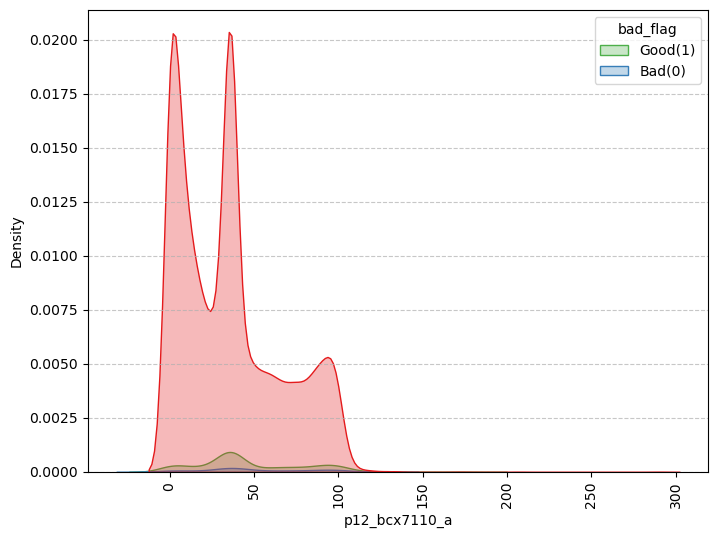

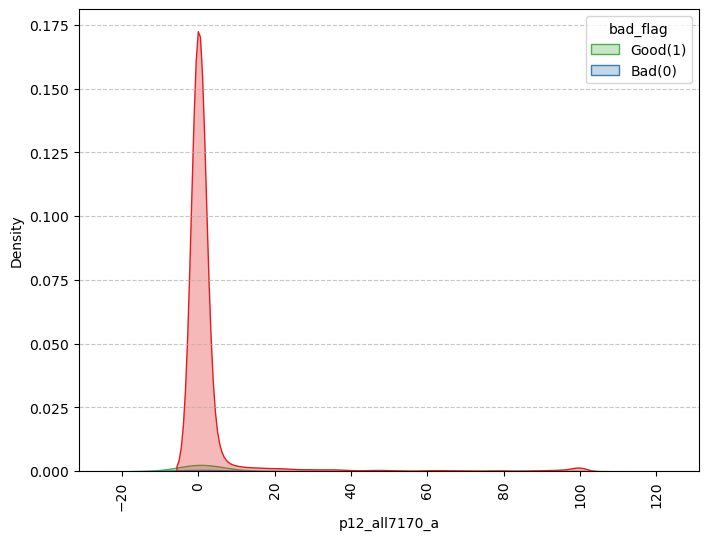

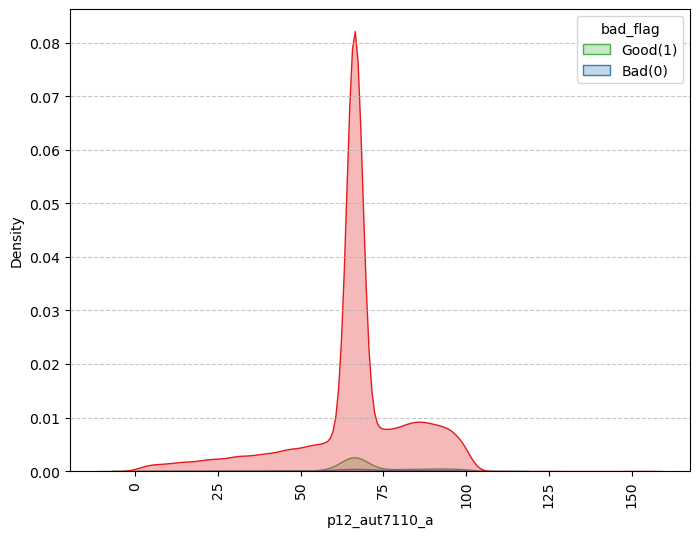

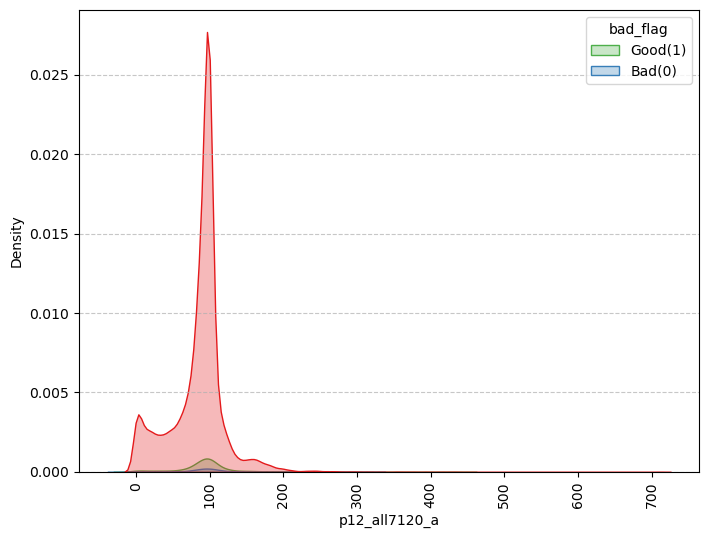

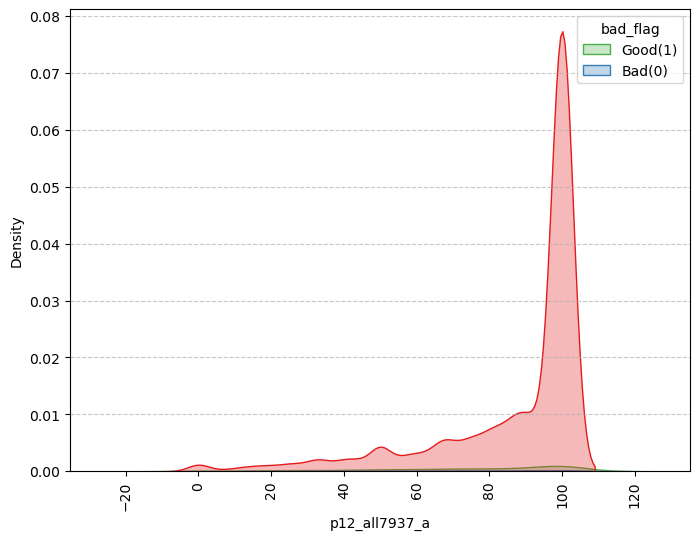

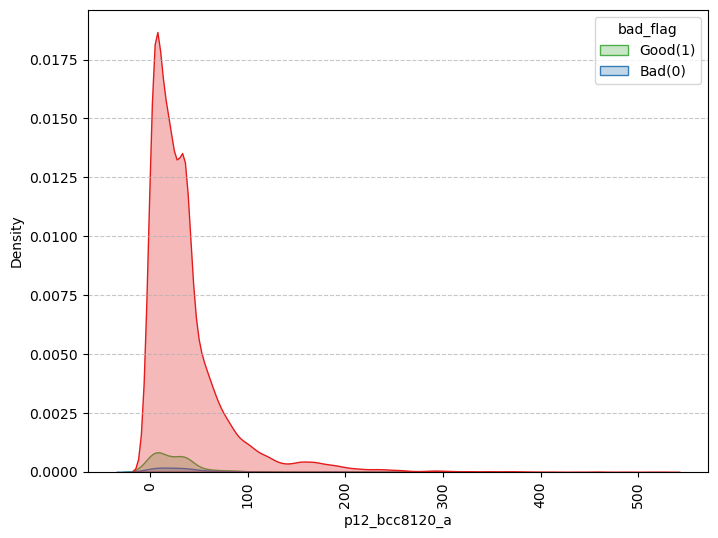

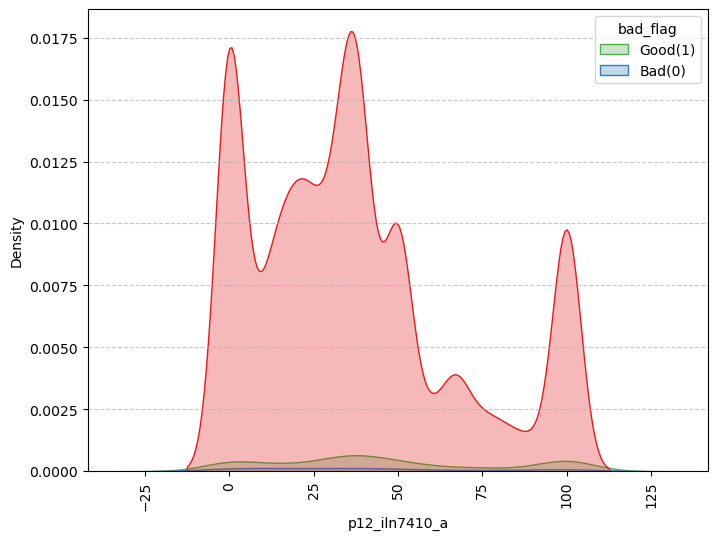

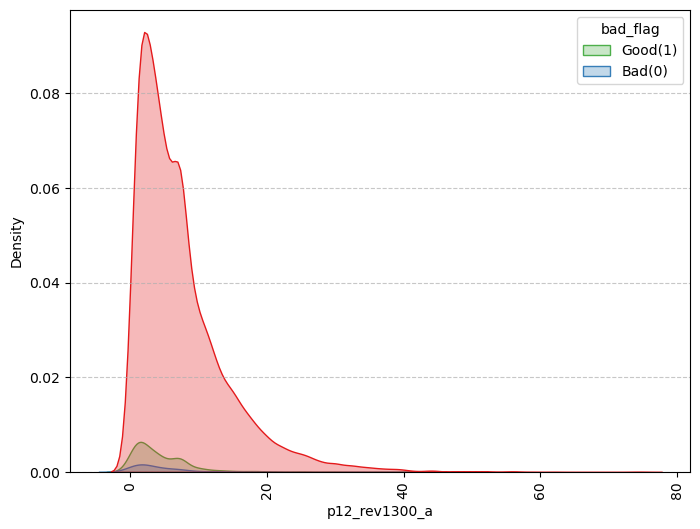

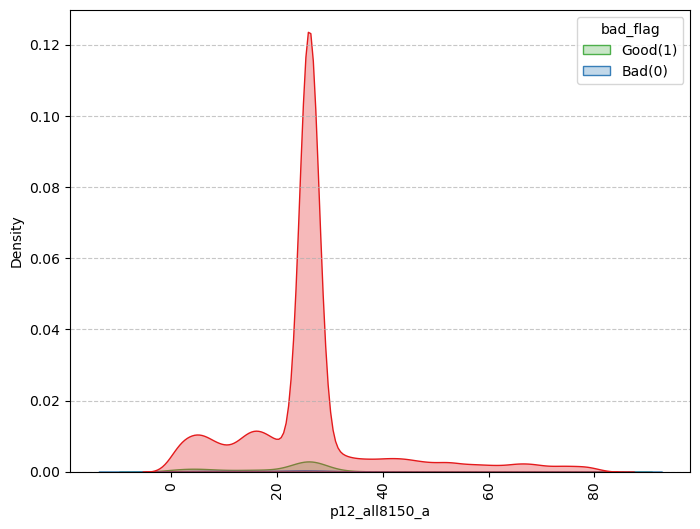

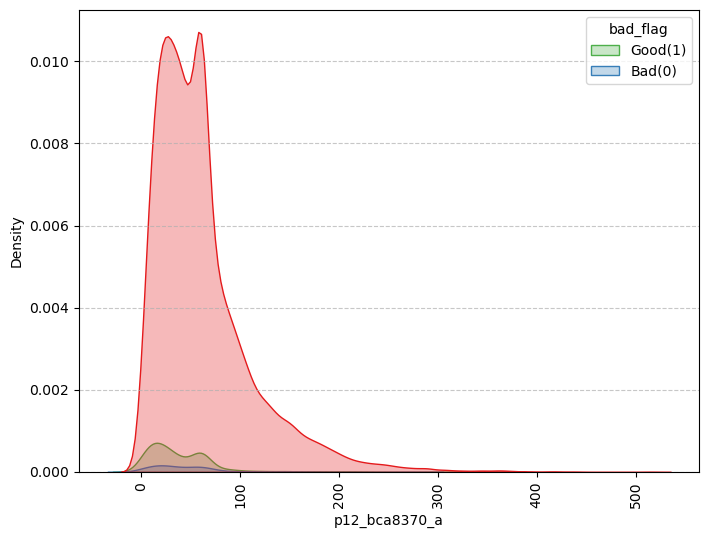

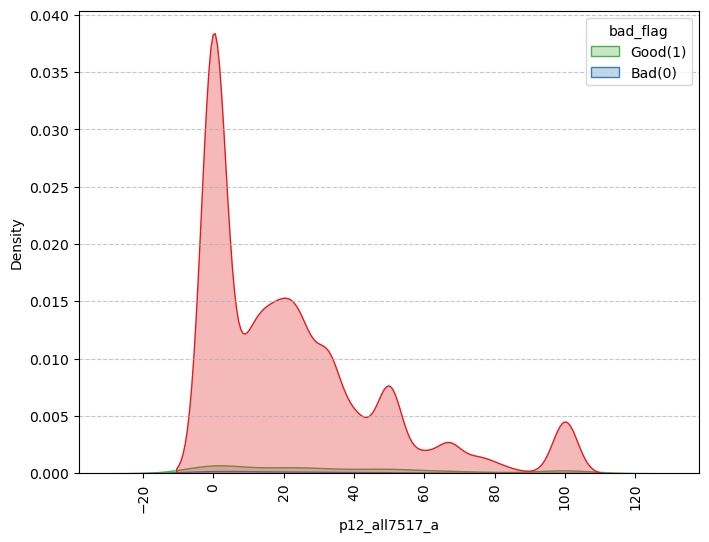

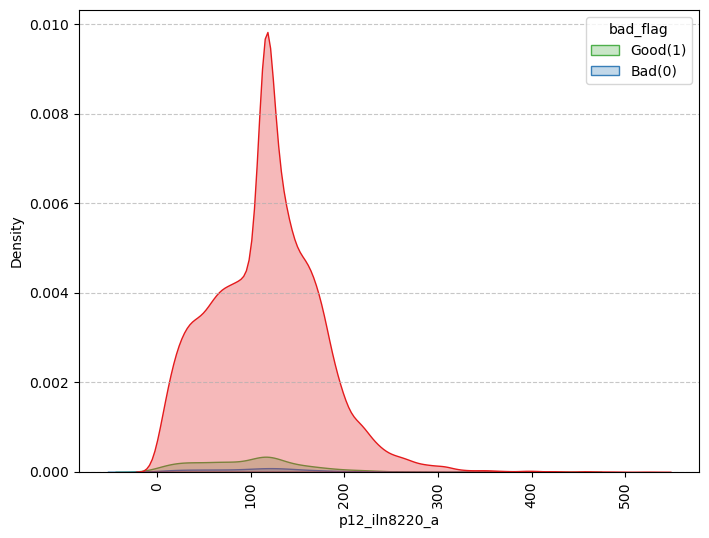

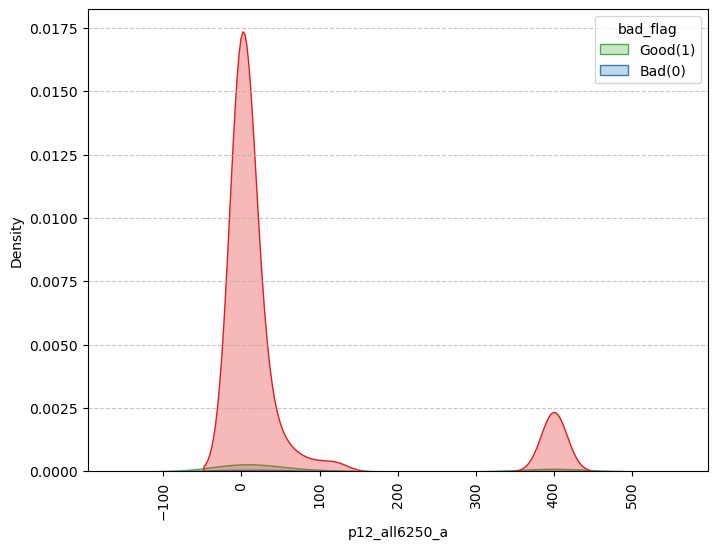

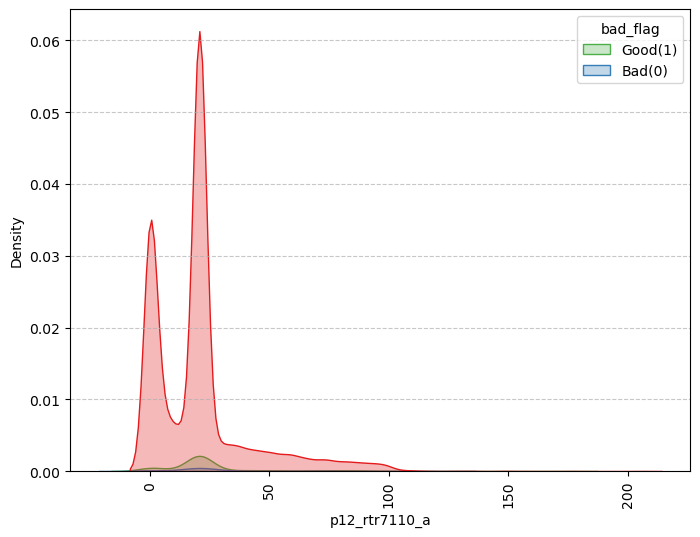

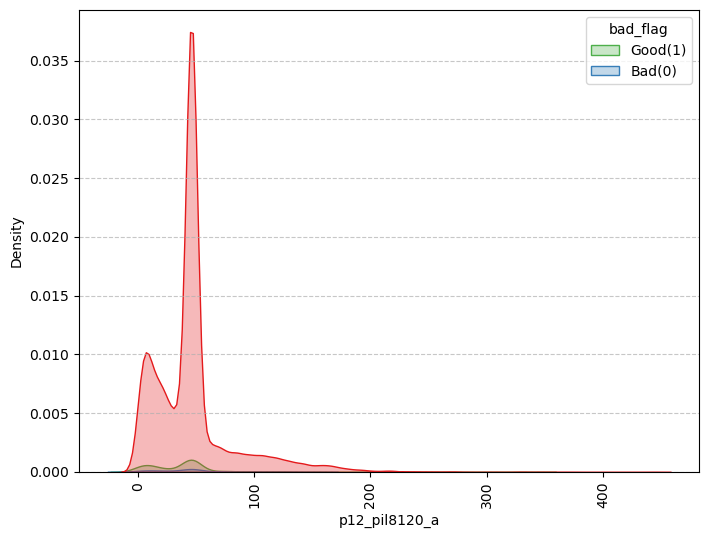

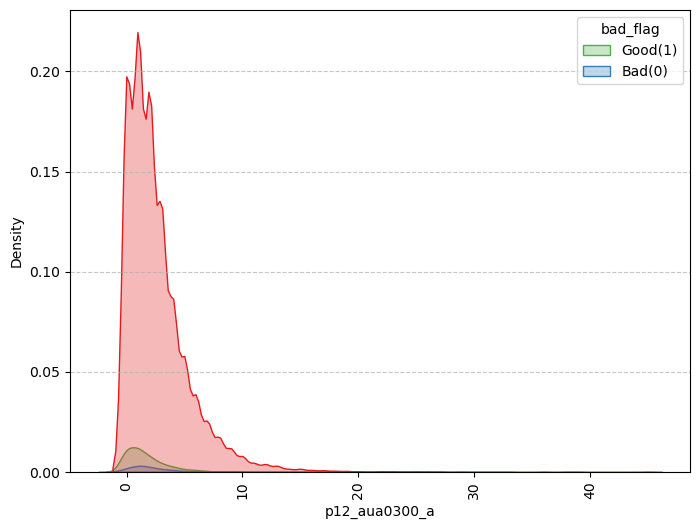

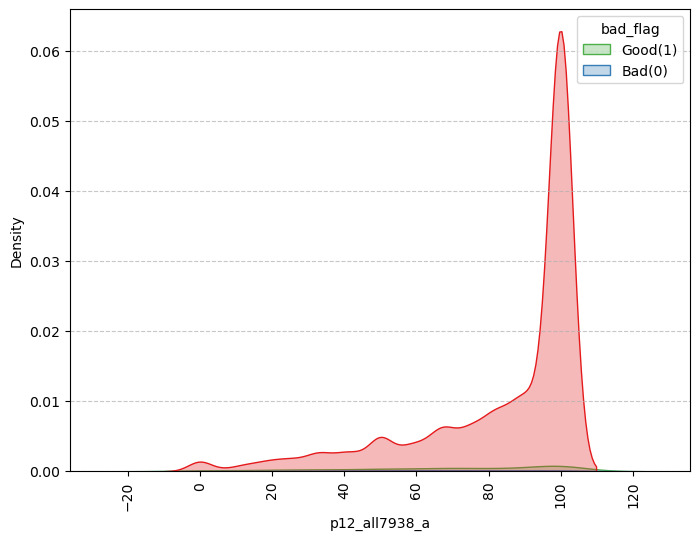

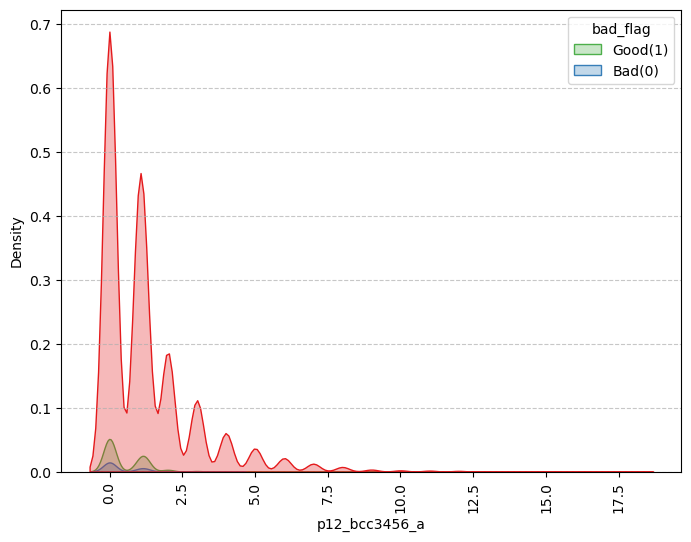

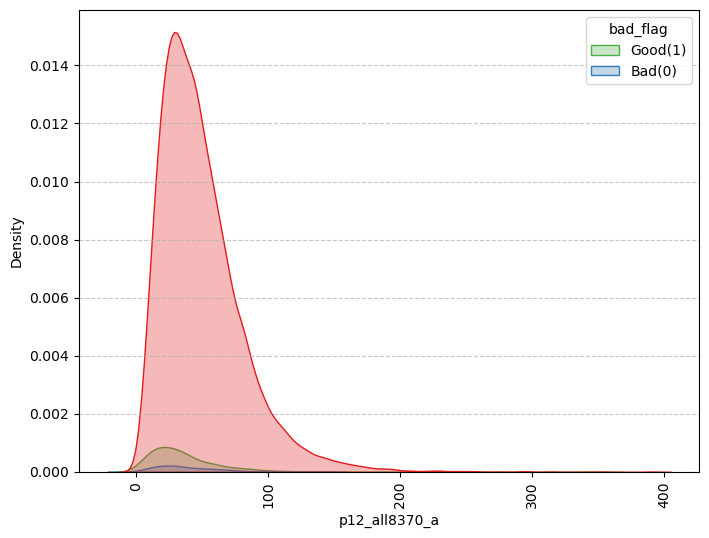

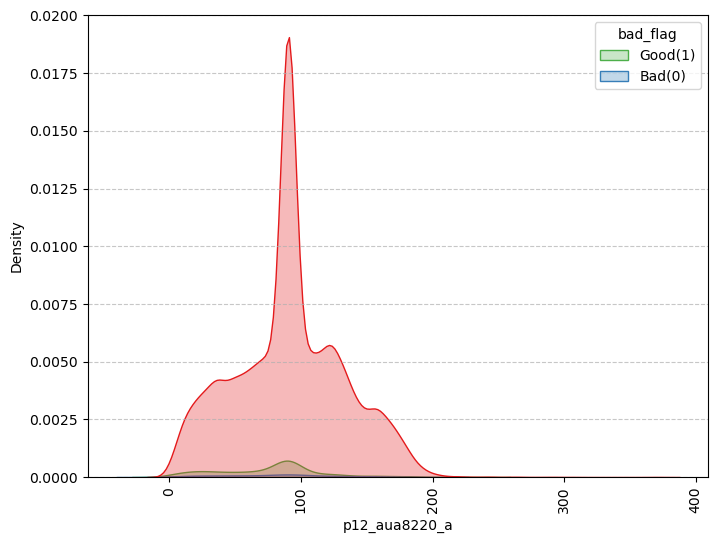

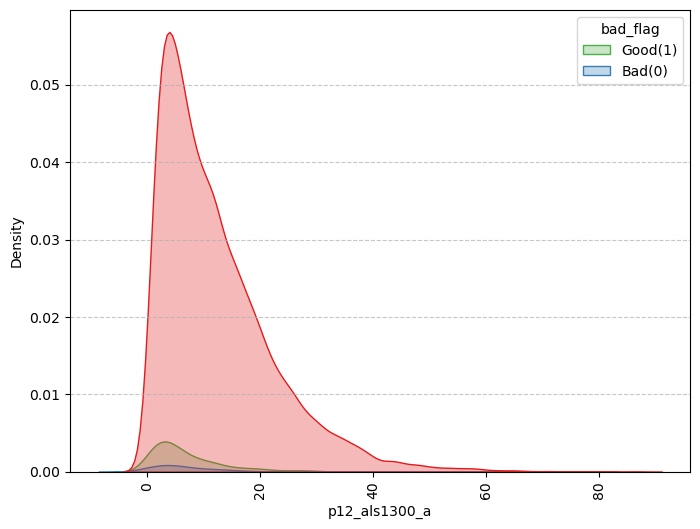

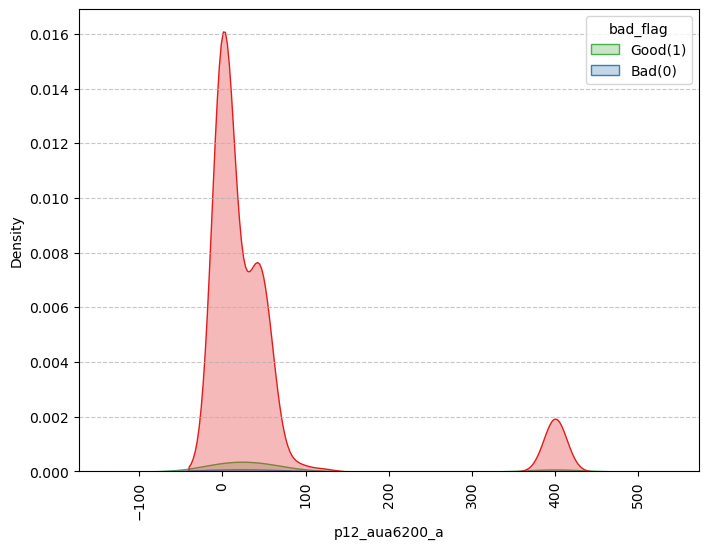

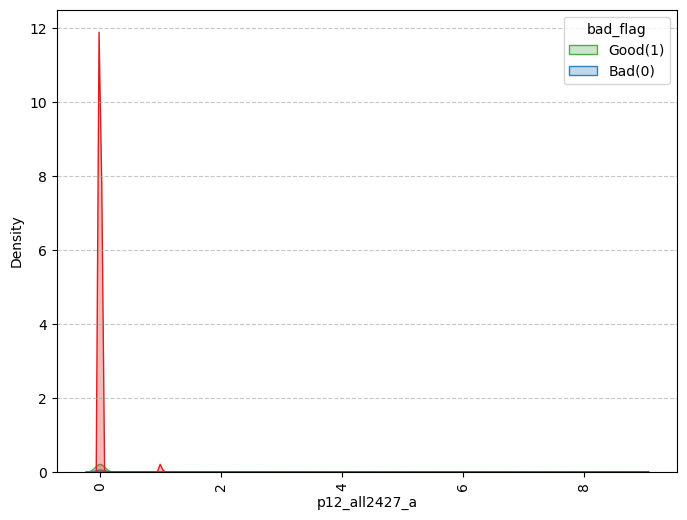

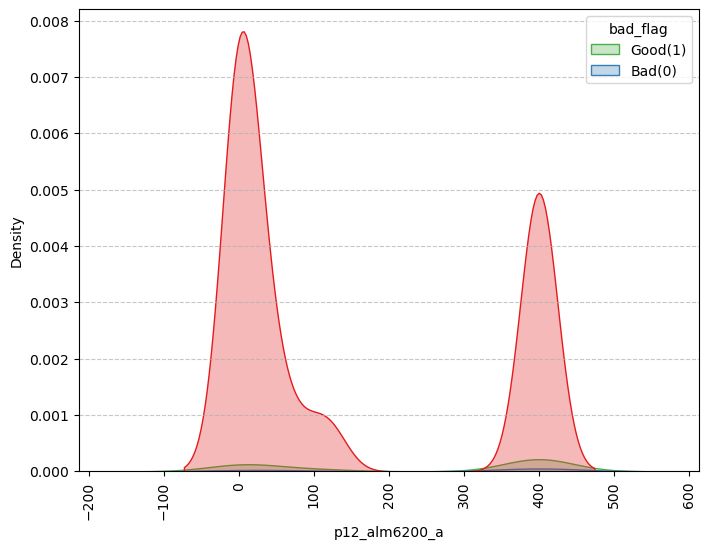

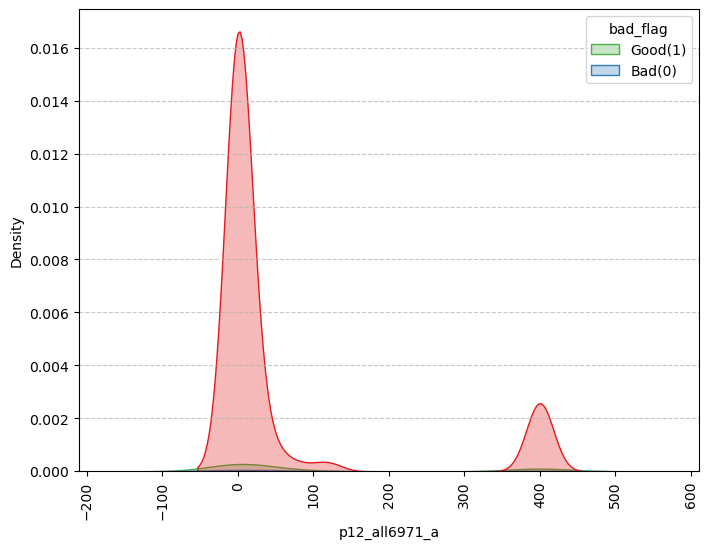

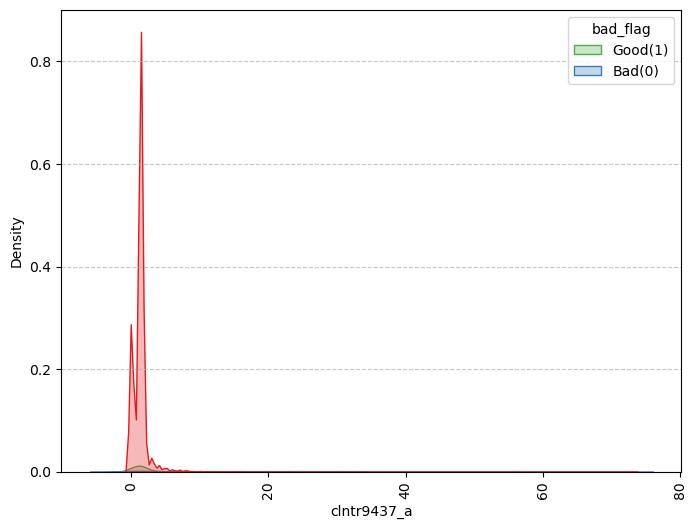

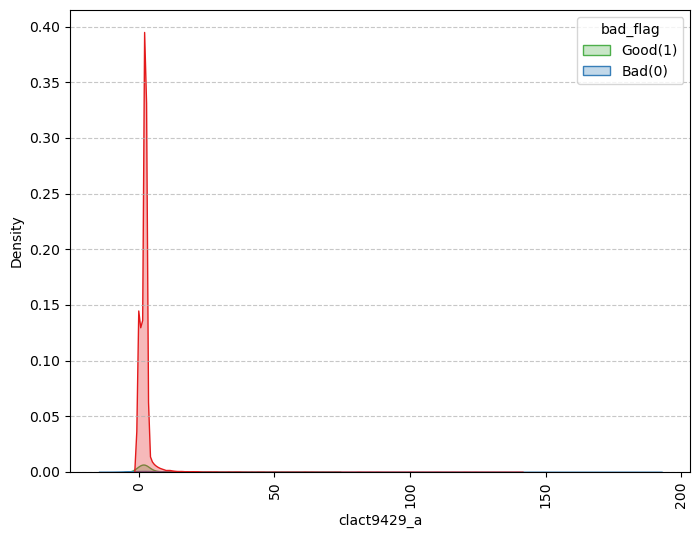

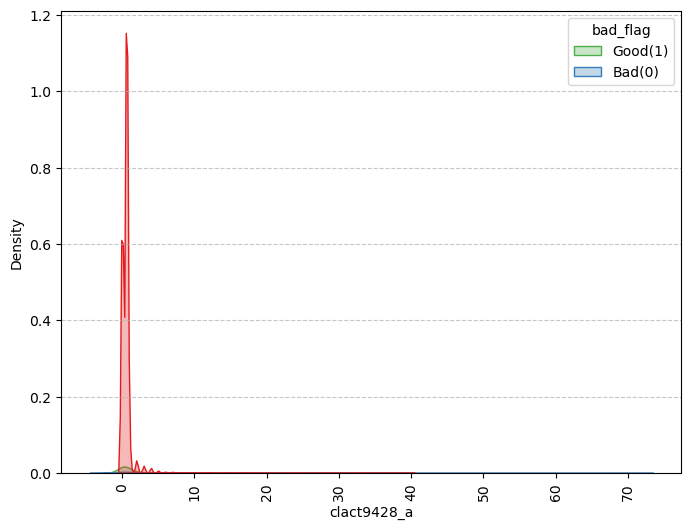

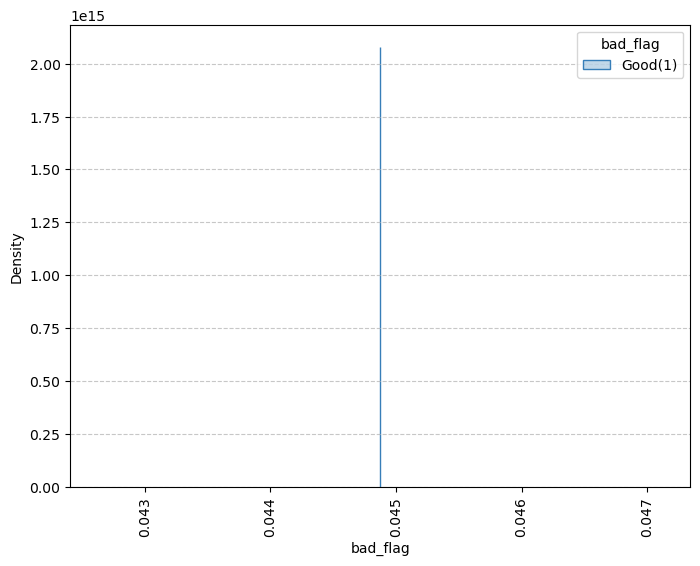

In [587]:
# Check the plot between the response and the other predictors using KDE plot 
# One plot shows the distribution of predictor's values for good performers (bad_flag=1) and another curve for bad performers (bad_flag=0)
numerical_predictors = training1.select_dtypes(include = ['float64', 'int64']).columns.tolist()
for predictor in numerical_predictors:
    plt.figure(figsize=(8,6))
    sns.kdeplot(data=training1, x= predictor , hue= 'bad_flag', fill = True , alpha =0.3, palette = 'Set1') 
    plt.title('')
    plt.xlabel(predictor) # Represents value of the predictor 
    plt.ylabel('Density') # Represnets the probability density function
    plt.xticks(rotation=90)
    plt.grid(axis='y',linestyle= '--', alpha=0.7)
    plt.legend(title ='bad_flag', labels = ['Good(1)', 'Bad(0)'])
plt.savefig('KDE plot between predictors and Response')
plt.show()                                                       

In [588]:
# Check the correlation between the Numerical/ Continuous features 
categ_columns1 = ['aprv_flag', 'bad_flag', 'Gender', 'Race','collateral_dlrinput_newused_1req']
numerical_columns = training1.drop(columns=categ_columns1)
correlation_matrix = numerical_columns.corr()
print(correlation_matrix)


                      fico  amtfinanced_1req  pti_1req  ltv_1req  \
fico              1.000000          0.072800 -0.143338 -0.221485   
amtfinanced_1req  0.072800          1.000000  0.225879  0.124731   
pti_1req         -0.143338          0.225879  1.000000  0.203309   
ltv_1req         -0.221485          0.124731  0.203309  1.000000   
p12_reh7120_a    -0.480731          0.040712  0.056031  0.170716   
p12_bcx7110_a    -0.524578         -0.017479  0.083650  0.168323   
p12_all7170_a    -0.335810         -0.071819 -0.004030  0.003880   
p12_aut7110_a    -0.076064          0.066072  0.046009  0.073914   
p12_all7120_a    -0.277161          0.097180 -0.012590  0.124956   
p12_all7937_a     0.622017          0.099806 -0.040983 -0.064248   
p12_bcc8120_a     0.135127         -0.031945 -0.058099 -0.085486   
p12_iln7410_a    -0.116381         -0.032976  0.077933  0.100701   
p12_rev1300_a     0.283754          0.128444 -0.117853 -0.050047   
p12_all8150_a     0.206172          0.006873 -0.

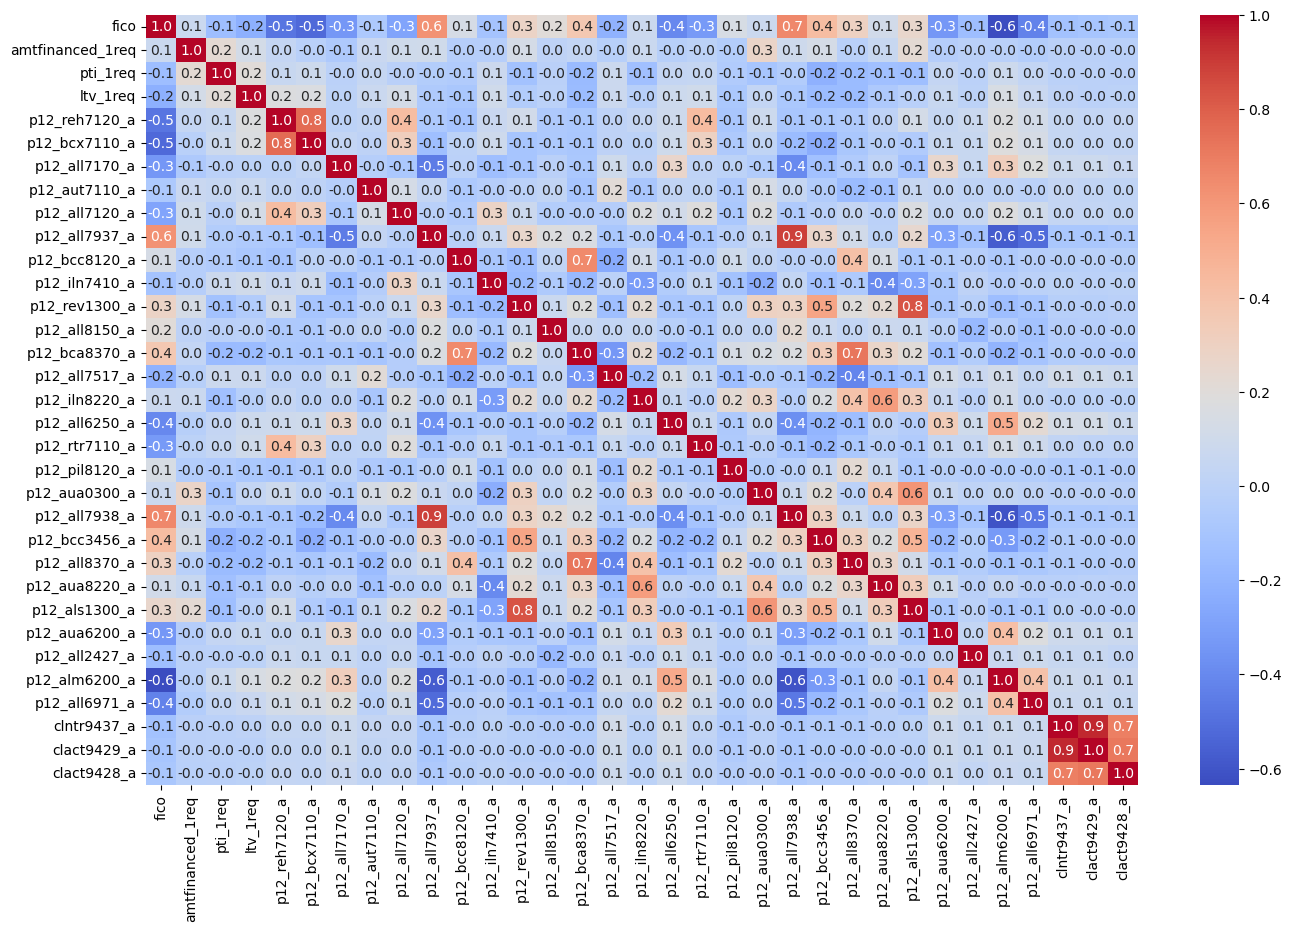

In [589]:
# Plot the coorelation matrix
plt.figure(figsize=(16,10))
sns.heatmap(correlation_matrix, annot= True, cmap = 'coolwarm', fmt = '.1f' , cbar =True, xticklabels= correlation_matrix.columns, yticklabels = correlation_matrix.columns)
plt.title('')
plt.savefig('Correlation_Matrix')
plt.show()

In [590]:
# Drop the features whose coorelation > 0.8
threshold = 0.8
# Create an empty set tostore the columns which are being dropped 
columns_drop = set()

# Iteration over the upper triangle 
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i,j])>=threshold:
            colname = correlation_matrix.columns[i]
            columns_drop.add(colname)
            
# Drop the coorelated columns 
training2 = training1.drop(columns= columns_drop) # Training2 dataframe contains the uncoorelated features and no missing values 
training2.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  581.0          0           32115.0                              NEW   
1  707.0          1           21436.0                             USED   
2  689.0          0           26930.0                             USED   
3  811.0          1           18140.0                             USED   
4  631.0          0            9874.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0     15.29    105.30      72.000000       72.00000            3.0   
1      4.63    102.12     100.000000       84.00000            0.0   
2      6.61    109.24      76.000000       13.00000            0.0   
3      3.08     49.03      12.000000       12.00000            0.0   
4      2.62    140.56      51.866406       35.86337            0.0   

   p12_aut7110_a  ...  p12_aua8220_a  p12_aua6200_a  p12_all2427_a  \
0      84.000000  ...      65.000000       1.000000              0   
1      66.256459  ...      90.306444      46.581424              0   
2      66.256459  ...      90.306444      46.581424              0   
3      34.000000  ...      49.000000       1.000000              0   
4      66.256459  ...     128.000000     400.000000              0   

   p12_alm6200_a  p12_all6971_a  clntr9437_a  clact9428_a  bad_flag  \
0            400          400.0     1.391309     0.614946       0.0   
1              1            1.0     1.391309     0.614946       0.0   
2             90            1.0     1.391309     0.614946       0.0   
3              1            1.0     1.391309     0.614946       0.0   
4            400           90.0     7.000000     5.000000       0.0   

      Gender   Race  
0     Female  White  
1       Male  White  
2  Undefined  White  
3     Female  Other  
4       Male  White  

[5 rows x 35 columns]

In [591]:
print(columns_drop) # Name these three features which have high correlation (> 0.8) 

{'p12_als1300_a', 'p12_all7938_a', 'clact9429_a'}


In [592]:
# Check for variance in the columns 
Variance = numerical_columns.var()
low_variance_col = Variance[Variance< 0.1].index.tolist()
print(low_variance_col) # There is only one continuous feature having variance less than 10 % . Dont drop. 

['p12_all2427_a']


In [593]:
# Standardization of the continuous variables 
scaler = StandardScaler()
columns_scale= training2.columns.difference(categ_columns1)  # Filter the continuous data to be scaled 
training_scaled = training2.copy() # Save a copy of the dataframe after dropping the columns having NA > 80 % 
training_scaled[columns_scale] = scaler.fit_transform(training2[columns_scale]) # Scaling of the data 
training_scaled[categ_columns1] = training2[categ_columns1] # Merge back the categorical columns in the scaled data 
training_scaled.head()


fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0 -1.487510          0          0.146570                              NEW   
1  0.040715          1         -0.550904                             USED   
2 -0.177603          0         -0.192076                             USED   
3  1.302107          1         -0.766175                             USED   
4 -0.881071          0         -1.306050                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0  1.304360  0.176875   5.645922e-01   1.194365e+00      -0.040748   
1 -0.915030  0.040058   1.349776e+00   1.590981e+00      -0.245411   
2 -0.502798  0.346390   6.767613e-01  -7.556654e-01      -0.245411   
3 -1.237737 -2.244096  -1.117945e+00  -7.887168e-01      -0.245411   
4 -1.333508  1.693908  -1.992525e-16  -2.348440e-16      -0.245411   

   p12_aut7110_a  ...  p12_aua8220_a  p12_aua6200_a  p12_all2427_a  \
0       1.013063  ...      -0.613977      -0.441400      -0.117198   
1       0.000000  ...       0.000000       0.000000      -0.117198   
2       0.000000  ...       0.000000       0.000000      -0.117198   
3      -1.841674  ...      -1.002163      -0.441400      -0.117198   
4       0.000000  ...       0.914509       3.422424      -0.117198   

   p12_alm6200_a  p12_all6971_a  clntr9437_a   clact9428_a  bad_flag  \
0       1.379889       2.563080     0.000000  7.541778e-17       0.0   
1      -0.820332      -0.431157     0.000000  7.541778e-17       0.0   
2      -0.329556      -0.431157     0.000000  7.541778e-17       0.0   
3      -0.820332      -0.431157     0.000000  7.541778e-17       0.0   
4       1.379889       0.236730     2.538105  2.978780e+00       0.0   

      Gender   Race  
0     Female  White  
1       Male  White  
2  Undefined  White  
3     Female  Other  
4       Male  White  

[5 rows x 35 columns]

In [594]:
# Encoding the categorical columns: Use one hot encoding to convert the categorical variables having no order 
# New=1, Used  = 0 ; No particular order
# Female = 1, Male = 2, Undefined = 3
# White =1, Other Races

training_encoded = pd.get_dummies(training_scaled, columns = ['collateral_dlrinput_newused_1req','Gender','Race'], drop_first= False)

# Convert the dummies columns to int type
training_encoded[training_encoded.columns.difference(training_scaled.columns)]= training_encoded[training_encoded.columns.difference(training_scaled.columns)].astype(int)
training_encoded.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715          1         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603          0         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107          1         -0.766175 -1.237737 -2.244096  -1.117945e+00   
4 -0.881071          0         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  ...  \
0   1.194365e+00      -0.040748       1.013063       0.097827  ...   
1   1.590981e+00      -0.245411       0.000000       0.392759  ...   
2  -7.556654e-01      -0.245411       0.000000      -0.250729  ...   
3  -7.887168e-01      -0.245411      -1.841674       0.365947  ...   
4  -2.348440e-16      -0.245411       0.000000       0.205075  ...   

   collateral_dlrinput_newused_1req_NEW  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      0              1            0   
1                                      1              0            1   
2                                      1              0            0   
3                                      1              1            0   
4                                      1              0            1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 0           0           0              0           0   
1                 0           0           0              0           0   
2                 1           0           0              0           0   
3                 0           0           0              0           1   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           1  
3           0  
4           1  

[5 rows x 42 columns]

In [595]:
# Check the distribution of the target variable to see if the dataset is balanced or not.
training_encoded['bad_flag'].astype(int).value_counts()

bad_flag
0    20648
1      958
Name: count, dtype: int64

In [596]:
# As the datasetis imbalanced, used SMOTE analysis 
!pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable


In [597]:
# Outliers 

In [598]:
training_encoded.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715          1         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603          0         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107          1         -0.766175 -1.237737 -2.244096  -1.117945e+00   
4 -0.881071          0         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  ...  \
0   1.194365e+00      -0.040748       1.013063       0.097827  ...   
1   1.590981e+00      -0.245411       0.000000       0.392759  ...   
2  -7.556654e-01      -0.245411       0.000000      -0.250729  ...   
3  -7.887168e-01      -0.245411      -1.841674       0.365947  ...   
4  -2.348440e-16      -0.245411       0.000000       0.205075  ...   

   collateral_dlrinput_newused_1req_NEW  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      0              1            0   
1                                      1              0            1   
2                                      1              0            0   
3                                      1              1            0   
4                                      1              0            1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 0           0           0              0           0   
1                 0           0           0              0           0   
2                 1           0           0              0           0   
3                 0           0           0              0           1   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           1  
3           0  
4           1  

[5 rows x 42 columns]

In [599]:
# Split the data into train and test and SMOTE 
X= training_encoded.drop(columns = 'bad_flag')
y = training_encoded['bad_flag'].astype(int)

X_train,X_test, y_train, y_test= train_test_split(X,y, test_size = 0.3, random_state= 45)

In [600]:
X_train.shape

(15124, 41)

In [601]:
X_train.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  \
1733  -0.092701          1         -0.149469  0.579831  0.206562   
16100 -0.881071          1         -1.326036 -1.123228  0.532685   
8950   1.156562          1          0.125932  0.200911 -0.845380   
2381   0.307548          1         -0.284363  0.417437  0.379089   
561    0.368192          1         -0.362477 -0.392453 -1.486870   

       p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  \
1733        0.143958      -0.127690      -0.245411       0.000000   
16100      -1.454453      -1.185333      -0.245411       0.898873   
8950       -1.426411      -1.152282      -0.245411       0.000000   
2381        0.901100       0.268927      -0.245411       0.000000   
561         0.200042       0.764697      -0.245411      -0.128832   

       p12_all7120_a  ...  collateral_dlrinput_newused_1req_NEW  \
1733       -0.760156  ...                                     1   
16100       0.607255  ...                                     0   
8950        0.151451  ...                                     0   
2381       -0.036233  ...                                     1   
561         0.365947  ...                                     0   

       collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
1733                                       0              0            1   
16100                                      1              1            0   
8950                                       1              1            0   
2381                                       0              0            1   
561                                        1              0            1   

       Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
1733                  0           0           1              0           0   
16100                 0           0           1              0           0   
8950                  0           0           1              0           0   
2381                  0           0           0              0           0   
561                   0           0           0              0           0   

       Race_White  
1733            0  
16100           0  
8950            0  
2381            1  
561             1  

[5 rows x 41 columns]

In [602]:
y_test.shape

(6482,)

In [603]:
# Fit the logistic Regression/ No SMOTE 

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

In [604]:
# Predict and Evaluate the model 
y_predict = model_lr.predict(X_test)  # Make predictions on the test set 

# Check Accuracy 
accuracy = accuracy_score(y_test, y_predict)

# Classification Report 
print (classification_report(y_test, y_predict))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6181
           1       0.33      0.00      0.01       301

    accuracy                           0.95      6482
   macro avg       0.64      0.50      0.49      6482
weighted avg       0.92      0.95      0.93      6482



In [605]:
# Confusion_Matrix
print (confusion_matrix(y_test, y_predict))

[[6179    2]
 [ 300    1]]


0.8041651594399513


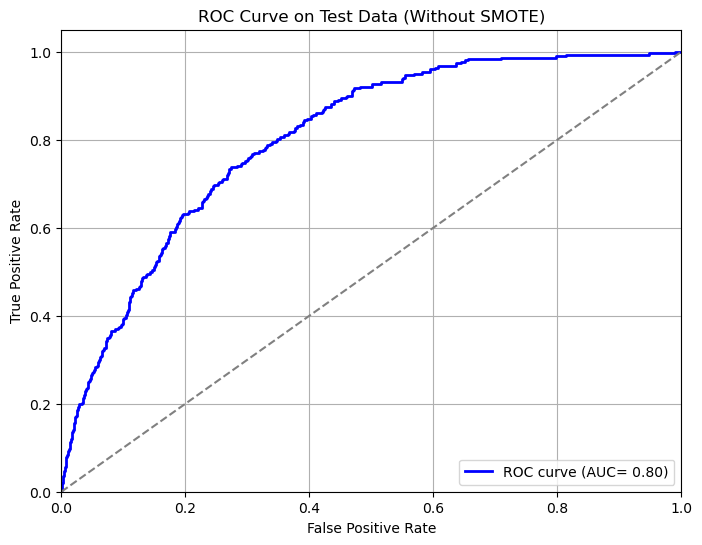

In [606]:
# ROC_AUC Curve 

# Compute probability of the positive class
y_prob = model_lr.predict_proba(X_test)[:,1]

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve (y_test, y_prob)

# AUC_score 
roc_auc= roc_auc_score(y_test,y_prob)
print(roc_auc)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2,label = f'ROC curve (AUC= {roc_auc:.2f})')
plt.plot([0,1],[0,1], color = 'gray', linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curve on Test Data (Without SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc ='lower right')
plt.grid(True)

In [607]:
# Logistic Regression using SMOTE to make the response variable balanced 

from imblearn.over_sampling import SMOTE 
# SMOTE on training set 
smote = SMOTE(random_state =45)

X_train_sm, y_train_sm =smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE 
print(y_train_sm.value_counts())

bad_flag
0    14467
1    14467
Name: count, dtype: int64


In [608]:
# Fit the model and check accuracy 

model_lr_sm = LogisticRegression()
model_lr_sm.fit(X_train_sm, y_train_sm)

# Predict and Evaluate the model 
y_predict = model_lr_sm.predict(X_test)  # Make predictions on the test set 

# Check Accuracy 
accuracy = accuracy_score(y_test, y_predict)

# Classification Report 
print (classification_report(y_test, y_predict))
# Confusion_Matrix
print (confusion_matrix(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6181
           1       0.15      0.23      0.18       301

    accuracy                           0.90      6482
   macro avg       0.56      0.58      0.57      6482
weighted avg       0.92      0.90      0.91      6482

[[5794  387]
 [ 231   70]]


0.7669307023291289


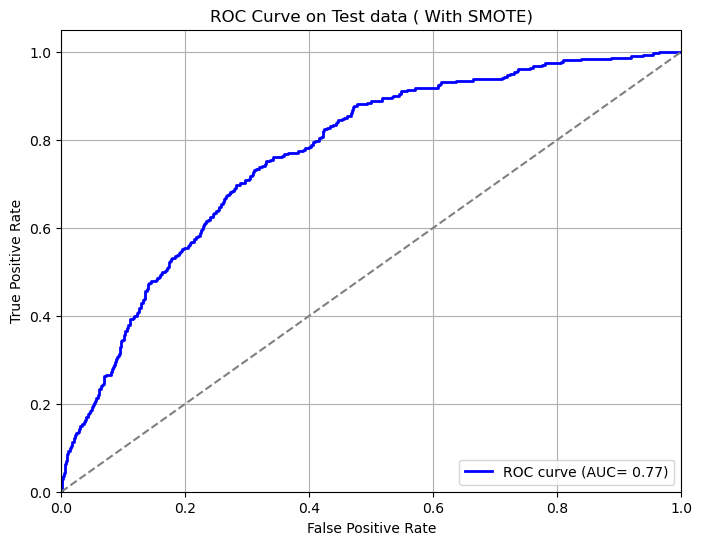

In [609]:
# ROC_AUC Curve/SMOTE

# Compute probability of the positive class
y_prob = model_lr_sm.predict_proba(X_test)[:,1]

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve (y_test, y_prob)

# AUC_score 
roc_auc= roc_auc_score(y_test,y_prob)
print(roc_auc)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2,label = f'ROC curve (AUC= {roc_auc:.2f})')
plt.plot([0,1],[0,1], color = 'gray', linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curve on Test data ( With SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc ='lower right')
plt.grid(True)

In [610]:
# EDA on validation dataset 
val_data.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  681.0          1           30966.0                             USED   
1  626.0          0           18363.0                             USED   
2  776.0          1           50768.0                              NEW   
3  721.0          1           49657.0                              NEW   
4    NaN          0           14412.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0      4.74     91.96           85.0           70.0            0.0   
1      3.37     87.90            NaN            NaN            0.0   
2      3.86    107.87           22.0           18.0            0.0   
3      3.71     99.36           93.0           83.0            0.0   
4      7.94    111.50           42.0           20.0            0.0   

   p12_aut7110_a  ...  clntr9437_a  clact9429_a  clall5010_a  clall2434_a  \
0            NaN  ...          NaN          NaN          NaN          NaN   
1           85.0  ...          3.0          3.0          NaN          NaN   
2           83.0  ...          NaN          NaN          NaN          NaN   
3           61.0  ...          NaN          NaN          NaN          NaN   
4            NaN  ...          NaN          NaN          NaN          NaN   

   cloil0214_a  cltra4405_a  clact9428_a  bad_flag     Gender      Race  
0          NaN          NaN          NaN       0.0  Undefined     White  
1          NaN          NaN          0.0       0.0     Female     White  
2          NaN          NaN          NaN       0.0     Female  Hispanic  
3          NaN          NaN          NaN       0.0       Male     White  
4          NaN          NaN          NaN       0.0     Female     White  

[5 rows x 43 columns]

In [611]:
# Drop the coorelated features and the features having NA values  > 80 % 
categ_columns1 = ['aprv_flag', 'bad_flag', 'Gender', 'Race','collateral_dlrinput_newused_1req']
Val_data1= val_data.drop(columns = ['p12_aua8151_a', 'clall5010_a', 'clall2434_a', 'cloil0214_a', 'cltra4405_a','p12_als1300_a', 'p12_all7938_a', 'clact9429_a'])
Val_data1.head()

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0  681.0          1           30966.0                             USED   
1  626.0          0           18363.0                             USED   
2  776.0          1           50768.0                              NEW   
3  721.0          1           49657.0                              NEW   
4    NaN          0           14412.0                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0      4.74     91.96           85.0           70.0            0.0   
1      3.37     87.90            NaN            NaN            0.0   
2      3.86    107.87           22.0           18.0            0.0   
3      3.71     99.36           93.0           83.0            0.0   
4      7.94    111.50           42.0           20.0            0.0   

   p12_aut7110_a  ...  p12_aua8220_a  p12_aua6200_a  p12_all2427_a  \
0            NaN  ...            NaN            NaN              0   
1           85.0  ...          152.0          400.0              0   
2           83.0  ...           84.0            1.0              0   
3           61.0  ...          138.0           60.0              0   
4            NaN  ...            NaN            NaN              0   

   p12_alm6200_a  p12_all6971_a  clntr9437_a  clact9428_a  bad_flag  \
0             30            1.0          NaN          NaN       0.0   
1            400          400.0          3.0          0.0       0.0   
2             30            1.0          NaN          NaN       0.0   
3             90            1.0          NaN          NaN       0.0   
4              1            1.0          NaN          NaN       0.0   

      Gender      Race  
0  Undefined     White  
1     Female     White  
2     Female  Hispanic  
3       Male     White  
4     Female     White  

[5 rows x 35 columns]

In [612]:
# Impute the missing values in contnuous columns with mean after dropping the categorical columns
Val_data2 = Val_data1.drop(columns=categ_columns1)
Val_data_filled = Val_data2.fillna(Val_data2.mean())
Val_data_filled.head()

fico  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0  681.000000           30966.0      4.74     91.96      85.000000   
1  626.000000           18363.0      3.37     87.90      51.010985   
2  776.000000           50768.0      3.86    107.87      22.000000   
3  721.000000           49657.0      3.71     99.36      93.000000   
4  702.706719           14412.0      7.94    111.50      42.000000   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  p12_all7937_a  \
0      70.000000            0.0      66.228121           85.0          100.0   
1      35.400495            0.0      85.000000           85.0           56.0   
2      18.000000            0.0      83.000000           94.0          100.0   
3      83.000000            0.0      61.000000           93.0           75.0   
4      20.000000            0.0      66.228121           42.0          100.0   

   ...  p12_aua0300_a  p12_bcc3456_a  p12_all8370_a  p12_aua8220_a  \
0  ...              0       1.000000             28      89.944651   
1  ...              8       1.204272             17     152.000000   
2  ...              9       1.000000             26      84.000000   
3  ...              7       2.000000             49     138.000000   
4  ...              0       0.000000              2      89.944651   

   p12_aua6200_a  p12_all2427_a  p12_alm6200_a  p12_all6971_a  clntr9437_a  \
0      45.123953              0             30            1.0     1.428257   
1     400.000000              0            400          400.0     3.000000   
2       1.000000              0             30            1.0     1.428257   
3      60.000000              0             90            1.0     1.428257   
4      45.123953              0              1            1.0     1.428257   

   clact9428_a  
0     0.670335  
1     0.000000  
2     0.670335  
3     0.670335  
4     0.670335  

[5 rows x 30 columns]

In [613]:
# Standardization of the validation data

Val_data_scaled = scaler.fit_transform(Val_data_filled) # Scaling of the data 

# Convert it back to dataframe 
Val_data_scaled = pd.DataFrame(Val_data_scaled, columns = Val_data_filled.columns)

# Combine the categorical columns 
Val_data_scaled[categ_columns1] = Val_data1[categ_columns1] # Brings back the categorical columns from original dataframe into the scaled dataframe 
Val_data_scaled.head()

fico  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -2.652055e-01          0.079733 -1.000153 -0.429812   9.607581e-01   
1 -9.371774e-01         -0.769376 -1.313359 -0.612421  -2.008471e-16   
2  8.954731e-01          1.413865 -1.201336  0.285783  -8.200455e-01   
3  2.235013e-01          1.339013 -1.235629 -0.096977   1.186892e+00   
4 -1.388988e-15         -1.035569 -0.268576  0.449052  -2.547110e-01   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  p12_all7937_a  \
0       1.143051       -0.25604       0.000000      -0.000293       0.613834   
1       0.000000       -0.25604       1.067615      -0.000293      -1.326745   
2      -0.574854       -0.25604       0.953869       0.232730       0.613834   
3       1.572528       -0.25604      -0.297339       0.206838      -0.488767   
4      -0.508781       -0.25604       0.000000      -1.113627       0.613834   

   ...  p12_all2427_a  p12_alm6200_a  p12_all6971_a  clntr9437_a  clact9428_a  \
0  ...      -0.119736      -0.662460      -0.435756     0.000000     0.000000   
1  ...      -0.119736       1.376615       2.533540     0.733326    -0.385261   
2  ...      -0.119736      -0.662460      -0.435756     0.000000     0.000000   
3  ...      -0.119736      -0.331799      -0.435756     0.000000     0.000000   
4  ...      -0.119736      -0.822279      -0.435756     0.000000     0.000000   

   aprv_flag  bad_flag     Gender      Race  collateral_dlrinput_newused_1req  
0          1       0.0  Undefined     White                              USED  
1          0       0.0     Female     White                              USED  
2          1       0.0     Female  Hispanic                               NEW  
3          1       0.0       Male     White                               NEW  
4          0       0.0     Female     White                              USED  

[5 rows x 35 columns]

In [614]:
Val_data_scaled = Val_data_scaled[Val_data1.columns]
Val_data_scaled.head()
#Val_data_encoded = train_final[train_filled_1_original.columns]

fico  aprv_flag  amtfinanced_1req collateral_dlrinput_newused_1req  \
0 -2.652055e-01          1          0.079733                             USED   
1 -9.371774e-01          0         -0.769376                             USED   
2  8.954731e-01          1          1.413865                              NEW   
3  2.235013e-01          1          1.339013                              NEW   
4 -1.388988e-15          0         -1.035569                             USED   

   pti_1req  ltv_1req  p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  \
0 -1.000153 -0.429812   9.607581e-01       1.143051       -0.25604   
1 -1.313359 -0.612421  -2.008471e-16       0.000000       -0.25604   
2 -1.201336  0.285783  -8.200455e-01      -0.574854       -0.25604   
3 -1.235629 -0.096977   1.186892e+00       1.572528       -0.25604   
4 -0.268576  0.449052  -2.547110e-01      -0.508781       -0.25604   

   p12_aut7110_a  ...  p12_aua8220_a  p12_aua6200_a  p12_all2427_a  \
0       0.000000  ...  -3.430919e-16   7.002522e-17      -0.119736   
1       1.067615  ...   1.498199e+00   3.497365e+00      -0.119736   
2       0.953869  ...  -1.435214e-01  -4.348492e-01      -0.119736   
3      -0.297339  ...   1.160198e+00   1.466060e-01      -0.119736   
4       0.000000  ...  -3.430919e-16   7.002522e-17      -0.119736   

   p12_alm6200_a  p12_all6971_a  clntr9437_a  clact9428_a  bad_flag  \
0      -0.662460      -0.435756     0.000000     0.000000       0.0   
1       1.376615       2.533540     0.733326    -0.385261       0.0   
2      -0.662460      -0.435756     0.000000     0.000000       0.0   
3      -0.331799      -0.435756     0.000000     0.000000       0.0   
4      -0.822279      -0.435756     0.000000     0.000000       0.0   

      Gender      Race  
0  Undefined     White  
1     Female     White  
2     Female  Hispanic  
3       Male     White  
4     Female     White  

[5 rows x 35 columns]

In [615]:
# Encoding the categorical columns 
Val_data_encoded = pd.get_dummies(Val_data_scaled, columns = ['collateral_dlrinput_newused_1req','Gender','Race'], drop_first= False)

# Convert the dummies columns to int type
Val_data_encoded[Val_data_encoded.columns.difference(Val_data_scaled.columns)]= Val_data_encoded[Val_data_encoded.columns.difference(Val_data_scaled.columns)].astype(int)

Val_data_encoded.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  \
0 -2.652055e-01          1          0.079733 -1.000153 -0.429812   
1 -9.371774e-01          0         -0.769376 -1.313359 -0.612421   
2  8.954731e-01          1          1.413865 -1.201336  0.285783   
3  2.235013e-01          1          1.339013 -1.235629 -0.096977   
4 -1.388988e-15          0         -1.035569 -0.268576  0.449052   

   p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  \
0   9.607581e-01       1.143051       -0.25604       0.000000      -0.000293   
1  -2.008471e-16       0.000000       -0.25604       1.067615      -0.000293   
2  -8.200455e-01      -0.574854       -0.25604       0.953869       0.232730   
3   1.186892e+00       1.572528       -0.25604      -0.297339       0.206838   
4  -2.547110e-01      -0.508781       -0.25604       0.000000      -1.113627   

   ...  collateral_dlrinput_newused_1req_NEW  \
0  ...                                     0   
1  ...                                     0   
2  ...                                     1   
3  ...                                     1   
4  ...                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      1              0            0   
1                                      1              1            0   
2                                      0              1            0   
3                                      0              0            1   
4                                      1              1            0   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 1           0           0              0           0   
1                 0           0           0              0           0   
2                 0           0           0              1           0   
3                 0           0           0              0           0   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           0  
3           1  
4           1  

[5 rows x 42 columns]

In [616]:
# check for missing values 
Val_data_encoded.isnull().sum()

fico                                      0
aprv_flag                                 0
amtfinanced_1req                          0
pti_1req                                  0
ltv_1req                                  0
p12_reh7120_a                             0
p12_bcx7110_a                             0
p12_all7170_a                             0
p12_aut7110_a                             0
p12_all7120_a                             0
p12_all7937_a                             0
p12_bcc8120_a                             0
p12_iln7410_a                             0
p12_rev1300_a                             0
p12_all8150_a                             0
p12_bca8370_a                             0
p12_all7517_a                             0
p12_iln8220_a                             0
p12_all6250_a                             0
p12_rtr7110_a                             0
p12_pil8120_a                             0
p12_aua0300_a                             0
p12_bcc3456_a                   

In [617]:
# There are 64 missing values in the target variable; Hence we will drop those rows 
Val_data_cleaned = Val_data_encoded.dropna(subset = ['bad_flag'])
Val_data_cleaned.isnull().sum()

fico                                     0
aprv_flag                                0
amtfinanced_1req                         0
pti_1req                                 0
ltv_1req                                 0
p12_reh7120_a                            0
p12_bcx7110_a                            0
p12_all7170_a                            0
p12_aut7110_a                            0
p12_all7120_a                            0
p12_all7937_a                            0
p12_bcc8120_a                            0
p12_iln7410_a                            0
p12_rev1300_a                            0
p12_all8150_a                            0
p12_bca8370_a                            0
p12_all7517_a                            0
p12_iln8220_a                            0
p12_all6250_a                            0
p12_rtr7110_a                            0
p12_pil8120_a                            0
p12_aua0300_a                            0
p12_bcc3456_a                            0
p12_all8370

In [618]:
Val_data_cleaned.shape

(5336, 42)

In [619]:
# Imputing outliers with median/ validation data

In [620]:
# Outliers Detection 

# Separate the categorical columns before imputing with median 
Categorical_columns = ['aprv_flag', 'bad_flag','collateral_dlrinput_newused_1req_USED','collateral_dlrinput_newused_1req_NEW',
                                    'Gender_Male','Gender_Female','Gender_Undefined','Race_Asian','Race_Black','Race_Hispanic','Race_Other','Race_White']
Valdata_foroutliers = Val_data_cleaned.drop(columns = Categorical_columns)

Q1v = Valdata_foroutliers.quantile(0.25)
Q3v = Valdata_foroutliers.quantile(0.75)
IQRv= Q3v-Q1v
outliers_val = ((Valdata_foroutliers<(Q1v-1.5*IQRv))|(Valdata_foroutliers>(Q3v+1.5*IQRv))).any(axis=1)
outlier_datav = Valdata_foroutliers[outliers_val]       
len(outlier_datav.columns) # All the  numerical continuos variables contain outliers 

30

In [621]:
# As all the columns contain outliers, we cant get rid of them. But we can impute them. 
# Impute the outlier with the median as some of the variables are very skewed 
median_valuesv = Valdata_foroutliers.median()
cleaned_datav = Valdata_foroutliers.copy()
cleaned_datav = np.where((cleaned_datav < (Q1v - 1.5 * IQRv)) | (cleaned_datav > (Q3v + 1.5 * IQRv )), median_valuesv, cleaned_datav)
cleaned_datav  = pd.DataFrame(cleaned_datav, columns = Valdata_foroutliers.columns)
cleaned_datav.shape

(5336, 30)

In [622]:
Categorical_columnsv = Val_data_cleaned[['aprv_flag', 'bad_flag','collateral_dlrinput_newused_1req_USED','collateral_dlrinput_newused_1req_NEW',
                                    'Gender_Male','Gender_Female','Gender_Undefined','Race_Asian','Race_Black','Race_Hispanic','Race_Other','Race_White']].astype(int)
Categorical_columnsv.head()

aprv_flag  bad_flag  collateral_dlrinput_newused_1req_USED  \
0          1         0                                      1   
1          0         0                                      1   
2          1         0                                      0   
3          1         0                                      0   
4          0         0                                      1   

   collateral_dlrinput_newused_1req_NEW  Gender_Male  Gender_Female  \
0                                     0            0              0   
1                                     0            0              1   
2                                     1            0              1   
3                                     1            1              0   
4                                     0            0              1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 1           0           0              0           0   
1                 0           0           0              0           0   
2                 0           0           0              1           0   
3                 0           0           0              0           0   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           0  
3           1  
4           1

# Validation_data/ Missing values treated/ Correlated variables dropped/ Categorical variables encoded/ Outliers imputed with median

In [623]:
cleaned_datav = cleaned_datav.reset_index(drop=True)
Categorical_columnsv = Categorical_columnsv.reset_index(drop=True)

Validation_data_finalnew = pd.concat([cleaned_datav, Categorical_columnsv], axis=1)
Validation_data_finalnew= Validation_data_finalnew[Val_data_cleaned.columns]
Validation_data_finalnew.shape

(5336, 42)

# Testing the model on the validation dataset

In [624]:
X_validation = Val_data_cleaned.drop(columns='bad_flag')
X_validation.shape

(5336, 41)

In [625]:
y_val = Val_data_cleaned['bad_flag'].astype(int)
y_val.shape

(5336,)

0.7847759639439691


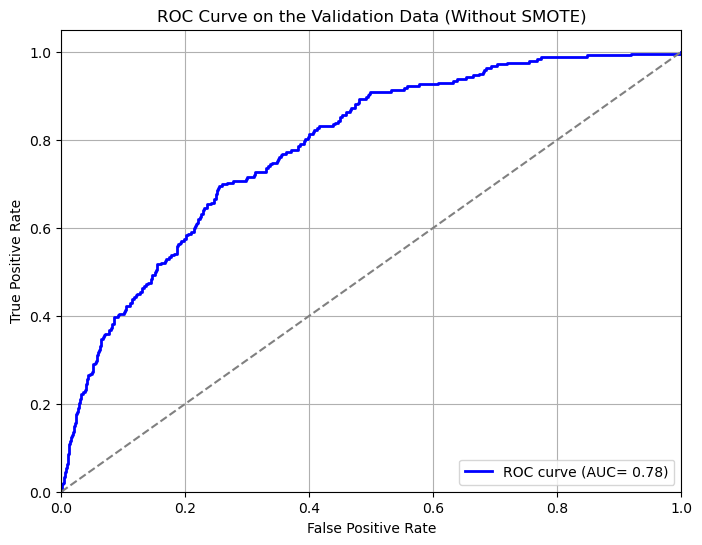

In [626]:
# ROC_AUC Curve on the Validation dataset and Logistic regression model without SMOTE 

# Compute probability of the positive class
y_val_prob = model_lr.predict_proba(X_validation)[:,1]

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve (y_val, y_val_prob)

# AUC_score 
roc_auc= roc_auc_score(y_val,y_val_prob)
print(roc_auc)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2,label = f'ROC curve (AUC= {roc_auc:.2f})')
plt.plot([0,1],[0,1], color = 'gray', linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curve on the Validation Data (Without SMOTE)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc ='lower right')
plt.grid(True)

In [627]:
# Feature Importance using SHAP 

In [628]:
# Model with Outliers 
# Check for Outliers in the training dataset
training_encoded.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715          1         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603          0         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107          1         -0.766175 -1.237737 -2.244096  -1.117945e+00   
4 -0.881071          0         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  ...  \
0   1.194365e+00      -0.040748       1.013063       0.097827  ...   
1   1.590981e+00      -0.245411       0.000000       0.392759  ...   
2  -7.556654e-01      -0.245411       0.000000      -0.250729  ...   
3  -7.887168e-01      -0.245411      -1.841674       0.365947  ...   
4  -2.348440e-16      -0.245411       0.000000       0.205075  ...   

   collateral_dlrinput_newused_1req_NEW  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      0              1            0   
1                                      1              0            1   
2                                      1              0            0   
3                                      1              1            0   
4                                      1              0            1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 0           0           0              0           0   
1                 0           0           0              0           0   
2                 1           0           0              0           0   
3                 0           0           0              0           1   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           1  
3           0  
4           1  

[5 rows x 42 columns]

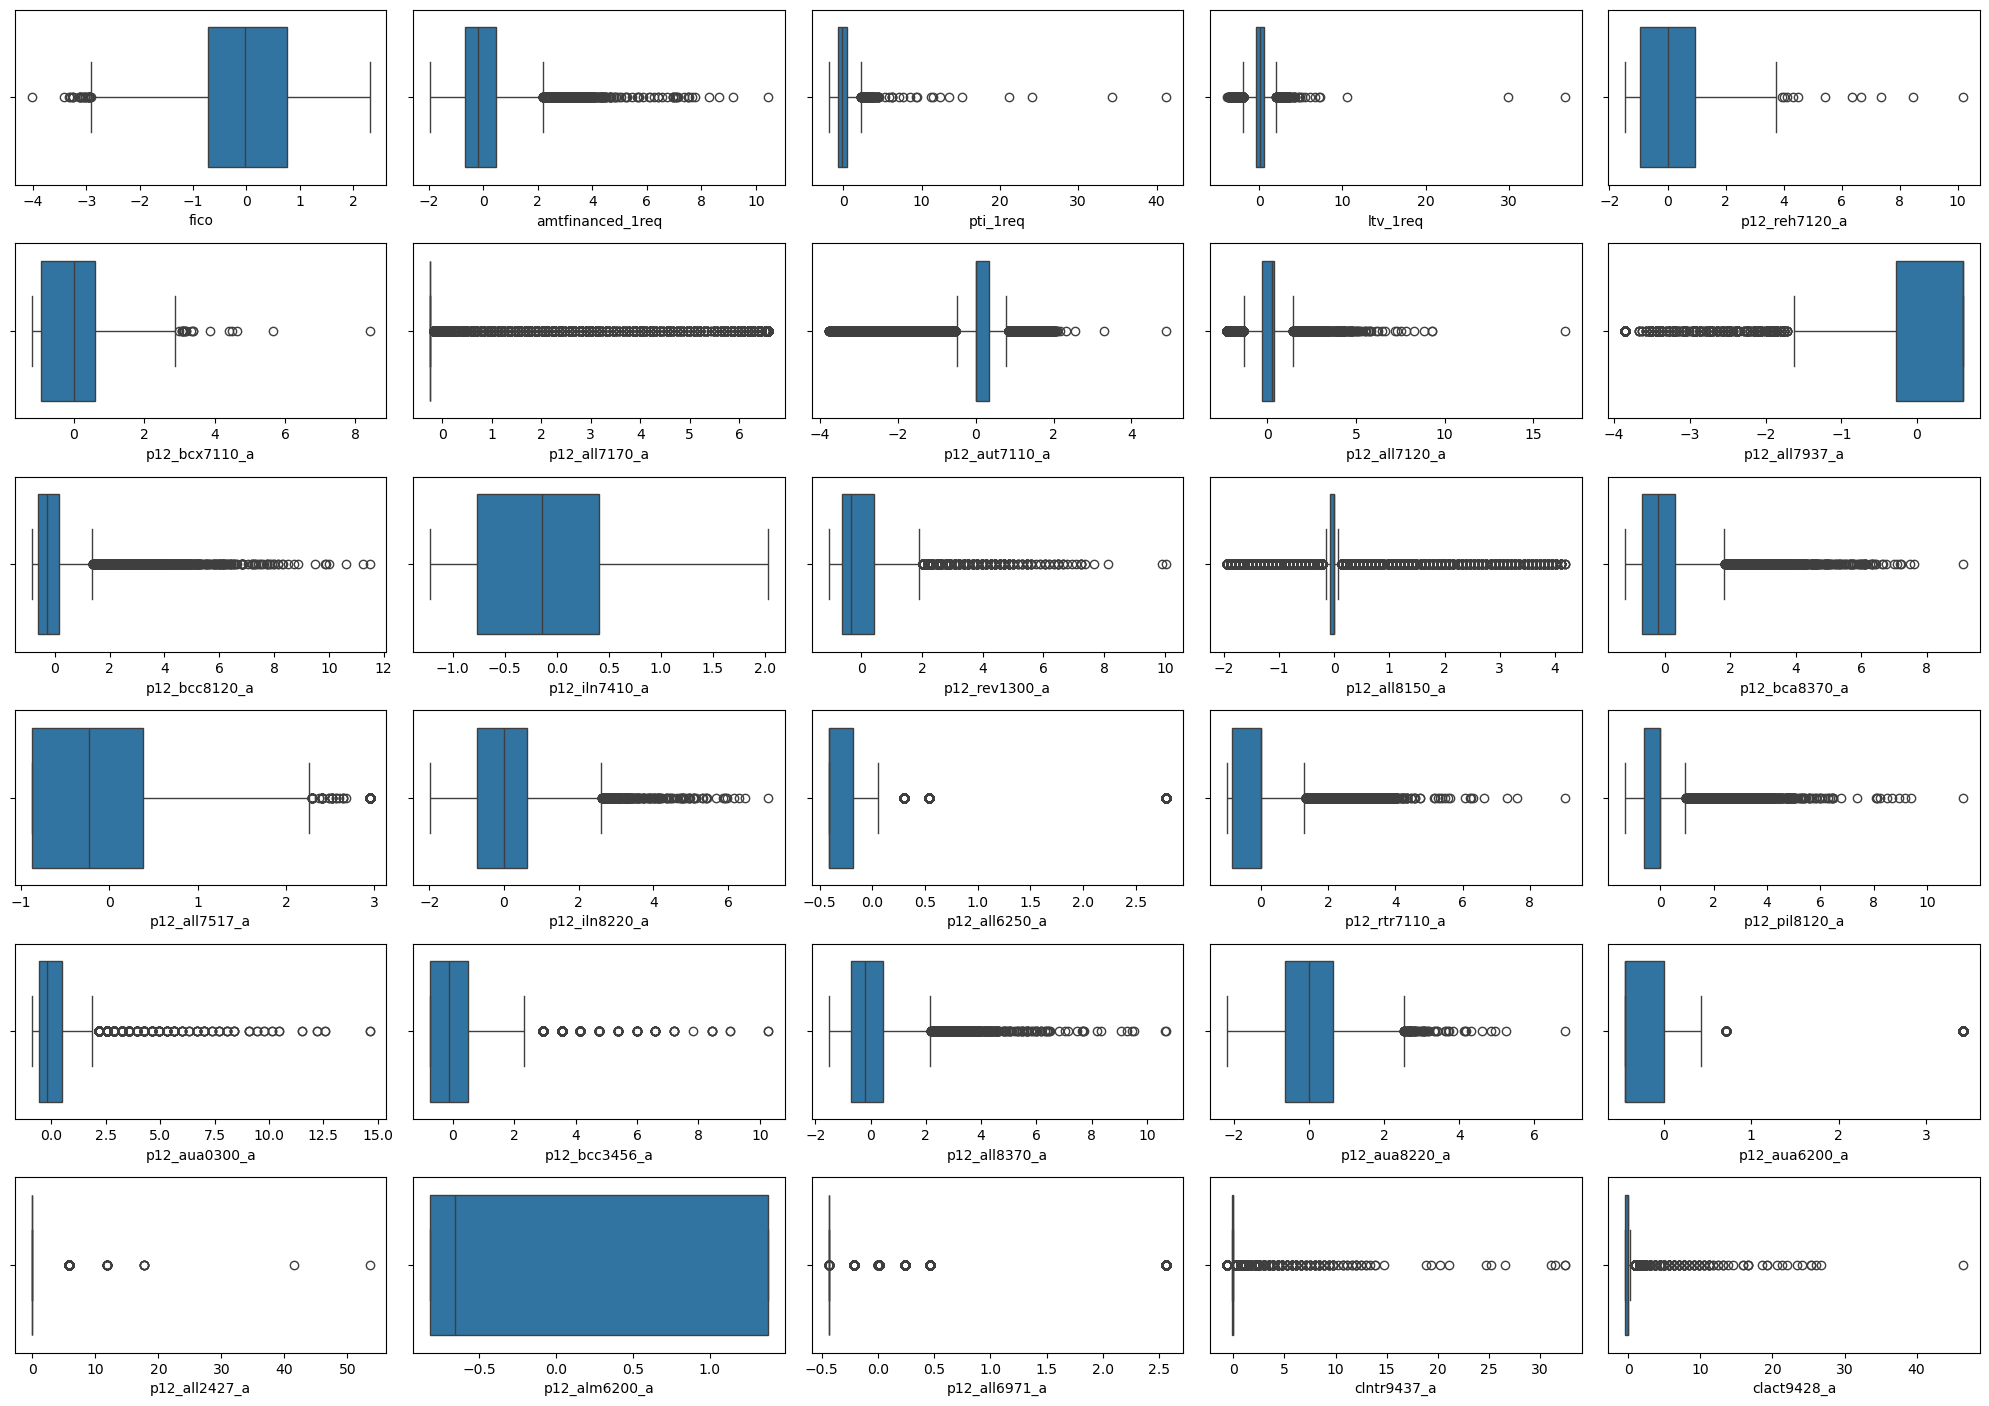

In [629]:
# Check for outliers in numerical columns 
Categorical_columns = ['aprv_flag', 'bad_flag','collateral_dlrinput_newused_1req_USED','collateral_dlrinput_newused_1req_NEW',
                                                       'Gender_Male','Gender_Female','Gender_Undefined','Race_Asian','Race_Black','Race_Hispanic','Race_Other','Race_White']
Training_foroutliers = training_encoded.drop(columns = Categorical_columns)
plt.figure(figsize = (20,20))
for i, column in enumerate(Training_foroutliers.columns):
    plt.subplot(8,5, i+1)
    sns.boxplot(x=Training_foroutliers[column])
    #plt.title(f'boxplot of {column}')
    #plt.tight_layout
    plt.tight_layout(rect = [0,0.03, 1,0.95])
plt.savefig('Box_plot_for_Outliers')
plt.show()

In [630]:
# Outliers Detection in Training Data
Q1 = Training_foroutliers.quantile(0.25)
Q3 = Training_foroutliers.quantile(0.75)
IQR= Q3-Q1
outliers = ((Training_foroutliers<(Q1-1.5*IQR))|(Training_foroutliers>(Q3+1.5*IQR))).any(axis=1)
outlier_data = Training_foroutliers[outliers]       
len(outlier_data.columns) # All the  numerical continuos variables contain outliers 

30

In [631]:
# As all the columns contain outliers, we cant get rid of them. But we can impute them. 
# Impute the outlier with the median as some of the variables are very skewed 
median_values = Training_foroutliers.median()
cleaned_data = Training_foroutliers.copy()
cleaned_data = np.where((cleaned_data < (Q1 - 1.5 * IQR)) | (cleaned_data > (Q3 + 1.5 * IQR )), median_values, cleaned_data)
cleaned_data  = pd.DataFrame(cleaned_data, columns = Training_foroutliers.columns)
cleaned_data.head()

fico  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107         -0.766175 -1.237737  0.097711  -1.117945e+00   
4 -0.881071         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  p12_all7937_a  \
0   1.194365e+00      -0.245411            0.0       0.097827      -0.506599   
1   1.590981e+00      -0.245411            0.0       0.392759       0.608385   
2  -7.556654e-01      -0.245411            0.0      -0.250729       0.608385   
3  -7.887168e-01      -0.245411            0.0       0.365947       0.608385   
4  -2.348440e-16      -0.245411            0.0       0.205075       0.608385   

   ...  p12_aua0300_a  p12_bcc3456_a  p12_all8370_a  p12_aua8220_a  \
0  ...       1.176055      -0.124847      -0.804652      -0.613977   
1  ...      -0.891859       1.708021      -0.212460       0.000000   
2  ...      -0.891859       1.097065       1.221267       0.000000   
3  ...      -0.202555      -0.124847      -0.617644      -1.002163   
4  ...      -0.202555       0.000000       0.348563       0.914509   

   p12_aua6200_a  p12_all2427_a  p12_alm6200_a  p12_all6971_a  clntr9437_a  \
0        -0.4414      -0.117198       1.379889      -0.431157          0.0   
1         0.0000      -0.117198      -0.820332      -0.431157          0.0   
2         0.0000      -0.117198      -0.329556      -0.431157          0.0   
3        -0.4414      -0.117198      -0.820332      -0.431157          0.0   
4        -0.4414      -0.117198       1.379889      -0.431157          0.0   

    clact9428_a  
0  7.541778e-17  
1  7.541778e-17  
2  7.541778e-17  
3  7.541778e-17  
4  7.541778e-17  

[5 rows x 30 columns]

# Cleaned_data -  Columns with > 80 % NA dropped, NA imputed with mean, Standardised ,Correlated variables dropped, Outliers Imputed with median.

In [632]:
# Merge the caetgorical columns to have the final cleaned dataset 
Categorical_columns = training_encoded[['aprv_flag', 'bad_flag','collateral_dlrinput_newused_1req_USED','collateral_dlrinput_newused_1req_NEW',
                                    'Gender_Male','Gender_Female','Gender_Undefined','Race_Asian','Race_Black','Race_Hispanic','Race_Other','Race_White']]
Cleaned_data_final = pd.concat([cleaned_data, Categorical_columns], axis =1)
Cleaned_data_final= Cleaned_data_final[training_encoded.columns]
Cleaned_data_final.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715          1         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603          0         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107          1         -0.766175 -1.237737  0.097711  -1.117945e+00   
4 -0.881071          0         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  ...  \
0   1.194365e+00      -0.245411            0.0       0.097827  ...   
1   1.590981e+00      -0.245411            0.0       0.392759  ...   
2  -7.556654e-01      -0.245411            0.0      -0.250729  ...   
3  -7.887168e-01      -0.245411            0.0       0.365947  ...   
4  -2.348440e-16      -0.245411            0.0       0.205075  ...   

   collateral_dlrinput_newused_1req_NEW  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      0              1            0   
1                                      1              0            1   
2                                      1              0            0   
3                                      1              1            0   
4                                      1              0            1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 0           0           0              0           0   
1                 0           0           0              0           0   
2                 1           0           0              0           0   
3                 0           0           0              0           1   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           1  
3           0  
4           1  

[5 rows x 42 columns]

In [145]:
# Build a Logistic Regression for the interpretation of the features without any regularization 

In [251]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [633]:
import statsmodels.api as sm
logit_model = sm.Logit (y_train, sm.add_constant(X_train))
result= logit_model.fit()

# Beta values: coefficients of the features
coefficients = result.params

# Odds ratio : Logit gives the log(odds) = log(sucess/failure)
odd_ratios = np.exp(coefficients)

# p-values and model summary 
p_values = result.pvalues

print(result.summary()) 

Optimization terminated successfully.
         Current function value: 0.152406
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               bad_flag   No. Observations:                15124
Model:                          Logit   Df Residuals:                    15085
Method:                           MLE   Df Model:                           38
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1473
Time:                        08:04:21   Log-Likelihood:                -2305.0
converged:                       True   LL-Null:                       -2703.1
Covariance Type:            nonrobust   LLR p-value:                1.294e-142
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.8234   2.4

In [634]:
print (result.aic.round(2), result.bic.round(2))

4687.96 4985.3


In [635]:
# Summary Table of significnat variables only 

summary_table = result.summary2().tables[1]
print(summary_table.columns)


Index(['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]'], dtype='object')


In [636]:
sig_variables = summary_table[summary_table['P>|z|'] <=0.05]
sig_summary = sig_variables[['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']]
print(sig_summary)

                  Coef.  Std.Err.         z         P>|z|    [0.025    0.975]
fico          -0.788818  0.089445 -8.818989  1.154982e-18 -0.964128 -0.613508
aprv_flag     -0.387027  0.103011 -3.757152  1.718584e-04 -0.588924 -0.185129
ltv_1req       0.191776  0.041629  4.606804  4.089054e-06  0.110185  0.273367
p12_aut7110_a  0.116495  0.048756  2.389347  1.687834e-02  0.020935  0.212056
p12_iln7410_a  0.147025  0.048684  3.019986  2.527863e-03  0.051606  0.242444
p12_rev1300_a -0.182477  0.075753 -2.408824  1.600403e-02 -0.330951 -0.034003
p12_all7517_a  0.130418  0.039943  3.265106  1.094232e-03  0.052131  0.208705
p12_aua0300_a -0.277708  0.076428 -3.633590  2.795046e-04 -0.427504 -0.127912
clntr9437_a    0.070873  0.032263  2.196745  2.803865e-02  0.007639  0.134106


In [637]:
# Observed that only 9 variables are statistically significant 

In [638]:
# Machine Learning Models on the dataset 
# 1. XGboost using grid search for hyper parameter tuning and 3 fold cross fold validation 

from sklearn.model_selection import GridSearchCV

xgbmodel1 = xgb.XGBClassifier()
#xgbmodel1.fit(X_train, y_train) 

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0,0.1,0.2] # Regularization Parameter
}

# There can be different performance metrics - accuracy, roc_auc score

grid_search1 = GridSearchCV(estimator=xgbmodel1, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1, refit=True)
grid_search1.fit(X_train, y_train)

# Train the best model
best_model1 = grid_search1.best_estimator_

# Make predictions and evaluate the model
xgb_pred1 = best_model1.predict(X_test)
y_pred_prob1 = best_model1.predict_proba(X_test)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy1 = accuracy_score(y_test, xgb_pred1) # Accuracy is calculated based on comapring predictions and actual y_test values 

print("Best Parameters:", grid_search1.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob1))
print("Classification Report:\n", classification_report(y_test, xgb_pred1))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred1))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
ROC AUC Score: 0.8191172067868472
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      6181
           1       0.00      0.00      0.00       301

    accuracy                           0.95      6482
   macro avg       0.48      0.50      0.49      6482
weighted avg       0.91      0.95      0.93      6482

Confusion Matrix:
 [[6181    0]
 [ 301    0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [639]:
# The XGboost above didnt perform well 
# 2. XGBoost with SMOTE: Helps to deal with Class Imbalance 
scale_pos_weight = float (sum(y==0)/sum(y==1))
xgbmodel2 = xgb.XGBClassifier(scale_pos_weight= scale_pos_weight)

#xgbmodel2.fit(X_train, y_train) 

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0,0.1,0.2] # Regularization Parameter
}

# There can be different performance metrics - accuracy, roc_auc score

grid_search2 = GridSearchCV(estimator=xgbmodel2, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)
grid_search2.fit(X_train, y_train)

# Train the best model
best_model2 = grid_search2.best_estimator_

# Make predictions and evaluate the model
xgb_pred2 = best_model2.predict(X_test)
y_pred_proba2 = best_model2.predict_proba(X_test)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy2 = accuracy_score(y_test, xgb_pred) # Accuracy is calculated based on comapring predictions and actual y_test values 

print("Best Parameters:", grid_search2.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba2))
print("Classification Report:\n", classification_report(y_test, xgb_pred2))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred2))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
ROC AUC Score: 0.8180674782489045
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.82      6181
           1       0.12      0.80      0.21       301

    accuracy                           0.71      6482
   macro avg       0.55      0.76      0.51      6482
weighted avg       0.95      0.71      0.80      6482

Confusion Matrix:
 [[4372 1809]
 [  59  242]]


In [640]:
# 3. StratifiedKFold to improve the performance of the model + SMOTE 
 
from sklearn.model_selection import StratifiedKFold
stratified_kfold =StratifiedKFold( n_splits =5, shuffle= True, random_state=42)


from imblearn.over_sampling import SMOTE 
# SMOTE on training set 
smote = SMOTE(sampling_strategy='auto', random_state =45)
X_train_sm, y_train_sm =smote.fit_resample(X_train, y_train)

# Set class weights to deal with imbalanced datasets 
class_weights = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weight = sum(class_weights.values()) / sum(class_weights.keys())

# Train XGBoost model
xgbmodel3 = xgb.XGBClassifier(scale_pos_weight=pos_weight)

grid_search3 = GridSearchCV(estimator=xgbmodel3, param_grid=param_grid, scoring='roc_auc', cv=stratified_kfold, verbose=2, n_jobs=-1)
grid_search3.fit(X_train, y_train)

# Train the best model
best_model3 = grid_search3.best_estimator_

# Make predictions and evaluate the model
xgb_pred3 = best_model3.predict(X_test)
y_pred_proba3 = best_model3.predict_proba(X_test)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy3 = accuracy_score(y_test, xgb_pred3) # Accuracy is calculated based on comapring predictions and actual y_test values 

print("Best Parameters:", grid_search3.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba3))
print("Classification Report:\n", classification_report(y_test, xgb_pred3))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_pred3))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
ROC AUC Score: 0.8217197595675528
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      6181
           1       0.16      0.48      0.25       301

    accuracy                           0.86      6482
   macro avg       0.57      0.68      0.58      6482
weighted avg       0.93      0.86      0.89      6482

Confusion Matrix:
 [[5451  730]
 [ 157  144]]


In [641]:
# Testing the performance metrics on the Validation dataset

# Make predictions and evaluate the model
xgb_pred_val = best_model3.predict(X_validation)
y_pred_proba_val = best_model3.predict_proba(X_validation)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy_val = accuracy_score(y_val, xgb_pred_val) # Accuracy is calculated based on comparing predictions and actual y_val values 
print(accuracy_val)
print("ROC AUC Score:", roc_auc_score(y_val, y_pred_proba_val))
print("Classification Report:\n", classification_report(y_val, xgb_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, xgb_pred_val))

0.8712518740629686
ROC AUC Score: 0.8077506513902274
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.89      0.93      5094
           1       0.17      0.46      0.25       242

    accuracy                           0.87      5336
   macro avg       0.57      0.68      0.59      5336
weighted avg       0.94      0.87      0.90      5336

Confusion Matrix:
 [[4537  557]
 [ 130  112]]


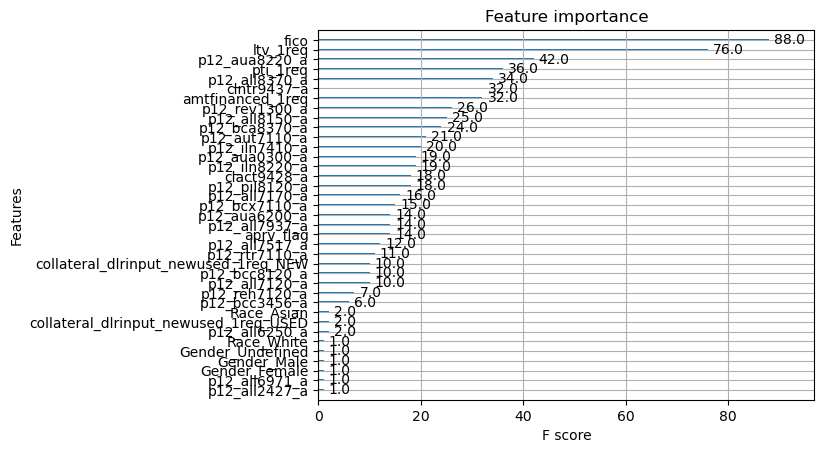

In [642]:
# Feature Importance from StratifiedKFold XBGoost model  
xgb.plot_importance(best_model3, importance_type= 'weight')
plt.show()

In [311]:
# Building a light GBM model 
! pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.4 MB 3.9 MB/s eta 0:00:01
   ---------------- ----------------------- 0.6/1.4 MB 7.4 MB/s eta 0:00:01
   -------------------------------- ------- 1.2/1.4 MB 9.2 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 9.2 MB/s eta 0:00:00


In [643]:
import lightgbm as lgb 
lgb_model = lgb.LGBMClassifier( 
    objective = 'binary',
    boosting_type = 'gbdt',
    num_leaves = 31,
    max_depth =-1,
    learning_rate=0.05,
    n_estimators =100)

# fit the model
lgb_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric = 'auc')


# Evaluate the model 
y_predlgb = lgb_model.predict(X_test)
y_pred_problgb = lgb_model.predict_proba(X_test)[:, 1] # Predicted Probability is required for the ROC_AUC score 


accuracy_lgb = accuracy_score(y_test, y_predlgb) # Accuracy is calculated based on comparing predictions and actual y_val values 
print(accuracy_lgb)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_problgb))
print("Classification Report:\n", classification_report(y_test, y_predlgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predlgb))

[LightGBM] [Info] Number of positive: 657, number of negative: 14467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 15124, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043441 -> initscore=-3.091941
[LightGBM] [Info] Start training from score -3.091941
0.9524838012958964
ROC AUC Score: 0.8165549661619764
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      6181
           1       0.18      0.01      0.01       301

    accuracy                           0.95      6482
   macro avg       0.57      0.50      0.49      6482
weighted avg       0.92      0.95      0.93      6482

Confusion Matrix:
 [[6172    9]
 [ 299    2]]


In [644]:
# Tuning of the Hyper parameters and performing Cross Validation 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 200],
    'max_depth': [-1, 10],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the best model
best_lgb_model = grid_search.best_estimator_


# Make predictions and evaluate the model
y_predlgb1 = best_lgb_model.predict(X_test)
y_pred_probalgb1 = best_lgb_model.predict_proba(X_test)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy_lgb1 = accuracy_score(y_test, y_predlgb1) # Accuracy is calculated based on comapring predictions and actual y_test values 

print("Best Parameters:", grid_search.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_probalgb1))
print("Classification Report:\n", classification_report(y_test, y_predlgb1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_predlgb1))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Number of positive: 657, number of negative: 14467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 15124, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043441 -> initscore=-3.091941
[LightGBM] [Info] Start training from score -3.091941
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.7}
ROC AUC Score: 0.814266579449078
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98      6181


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [383]:
# Feature Importance : Check the impact of Gender on the loan_approval_rate
gender_approval_rate = training.groupby('Gender')['aprv_flag'].mean()
print(gender_approval_rate)

Gender
Female       0.728821
Male         0.743788
Undefined    0.758311
Name: aprv_flag, dtype: float64


In [ ]:
# The approval rate for female is less; yet this feature is not important in the XGBoost Model (Model_importance).
# Hence we cant say that model is baised towards feamle 

In [385]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ----------------- ---------------------- 194.6/456.2 kB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 5.7 MB/s eta 0:00:00


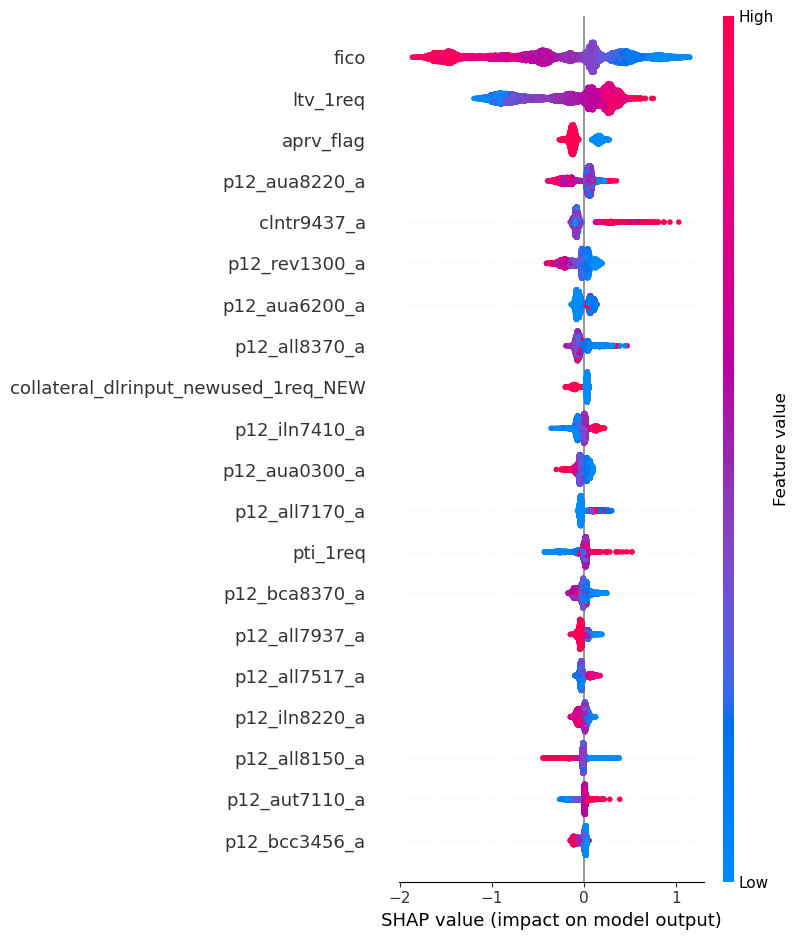

In [645]:
# SHAP
import shap
explainer = shap.Explainer(best_model3)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

In [646]:
# Force Plot: Shows contribution of each feature for a single instance (for example, for the rejected loan applicant)

In [647]:
shap.initjs()
shap.force_plot(shap_values[0]) # This shows the first row of the dataset ( first loan application) # Hence we can check 

In [648]:
print(X_train.columns)

Index(['fico', 'aprv_flag', 'amtfinanced_1req', 'pti_1req', 'ltv_1req',
       'p12_reh7120_a', 'p12_bcx7110_a', 'p12_all7170_a', 'p12_aut7110_a',
       'p12_all7120_a', 'p12_all7937_a', 'p12_bcc8120_a', 'p12_iln7410_a',
       'p12_rev1300_a', 'p12_all8150_a', 'p12_bca8370_a', 'p12_all7517_a',
       'p12_iln8220_a', 'p12_all6250_a', 'p12_rtr7110_a', 'p12_pil8120_a',
       'p12_aua0300_a', 'p12_bcc3456_a', 'p12_all8370_a', 'p12_aua8220_a',
       'p12_aua6200_a', 'p12_all2427_a', 'p12_alm6200_a', 'p12_all6971_a',
       'clntr9437_a', 'clact9428_a', 'collateral_dlrinput_newused_1req_NEW',
       'collateral_dlrinput_newused_1req_USED', 'Gender_Female', 'Gender_Male',
       'Gender_Undefined', 'Race_Asian', 'Race_Black', 'Race_Hispanic',
       'Race_Other', 'Race_White'],
      dtype='object')


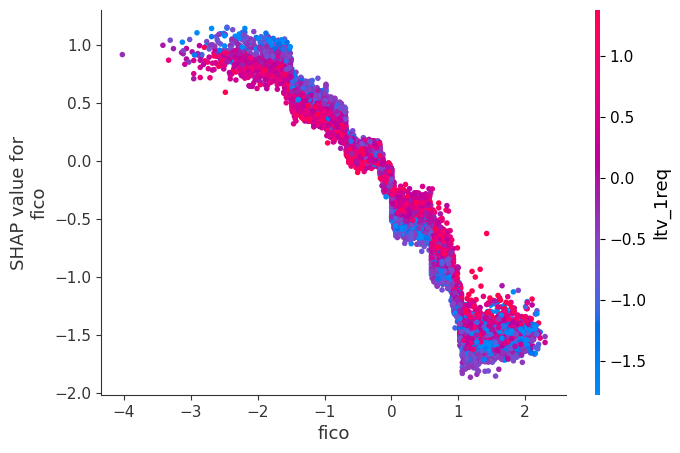

In [649]:
# Dependence Plot to check how a particular feature influences the output. eg: 'fico'
shap.dependence_plot('fico', shap_values.values, X_train)

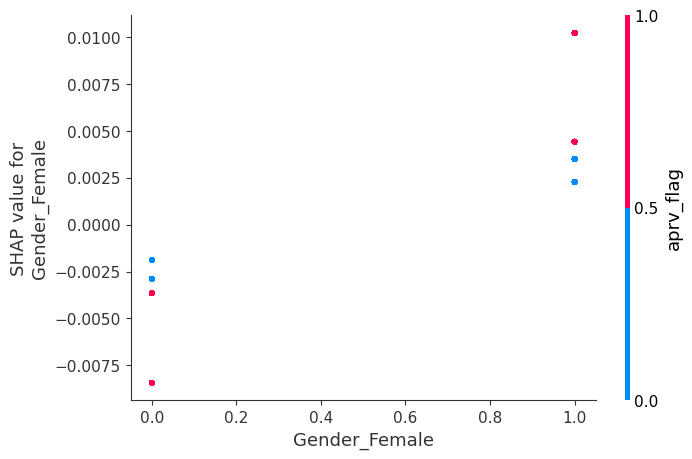

In [650]:
# Check how gender influences the output; 
shap.dependence_plot('Gender_Female', shap_values.values, X_train)

In [401]:
# Check the loan approval rate by race 
approval_rate_race = training.groupby('Race')['aprv_flag'].mean()
print(approval_rate_race)

Race
Asian       0.745487
Black       0.724243
Hispanic    0.738487
Other       0.739070
White       0.741318
Name: aprv_flag, dtype: float64


# 1. Statsmodel on cleaned data/ Outliers Removed

In [651]:
# Cleaned_data 
Cleaned_data_final.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  p12_reh7120_a  \
0 -1.487510          0          0.146570  1.304360  0.176875   5.645922e-01   
1  0.040715          1         -0.550904 -0.915030  0.040058   1.349776e+00   
2 -0.177603          0         -0.192076 -0.502798  0.346390   6.767613e-01   
3  1.302107          1         -0.766175 -1.237737  0.097711  -1.117945e+00   
4 -0.881071          0         -1.306050 -1.333508  1.693908  -1.992525e-16   

   p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  ...  \
0   1.194365e+00      -0.245411            0.0       0.097827  ...   
1   1.590981e+00      -0.245411            0.0       0.392759  ...   
2  -7.556654e-01      -0.245411            0.0      -0.250729  ...   
3  -7.887168e-01      -0.245411            0.0       0.365947  ...   
4  -2.348440e-16      -0.245411            0.0       0.205075  ...   

   collateral_dlrinput_newused_1req_NEW  \
0                                     1   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   collateral_dlrinput_newused_1req_USED  Gender_Female  Gender_Male  \
0                                      0              1            0   
1                                      1              0            1   
2                                      1              0            0   
3                                      1              1            0   
4                                      1              0            1   

   Gender_Undefined  Race_Asian  Race_Black  Race_Hispanic  Race_Other  \
0                 0           0           0              0           0   
1                 0           0           0              0           0   
2                 1           0           0              0           0   
3                 0           0           0              0           1   
4                 0           0           0              0           0   

   Race_White  
0           1  
1           1  
2           1  
3           0  
4           1  

[5 rows x 42 columns]

In [652]:
# Split the data into train and test and SMOTE 
X1= training_encoded.drop(columns = ['bad_flag','Gender_Male','Race_White','collateral_dlrinput_newused_1req_USED'] )
y1 = training_encoded['bad_flag'].astype(int)

X_train1,X_test1, y_train1, y_test1= train_test_split(X1,y1, test_size = 0.3, random_state= 42)

In [653]:
X_train1.shape

(15124, 38)

In [665]:
# Statsmodel 
import statsmodels.api as sm
logit_model_new = sm.Logit (y_train1, sm.add_constant(X_train1))
result_new= logit_model_new.fit()

# Beta values: coefficients of the features
coefficients_new = result_new.params

# Odds ratio : Logit gives the log(odds) = log(sucess/failure)
odd_ratios_new = np.exp(coefficients_new)

# p-values and model summary 
p_values_new = result_new.pvalues

print(result_new.summary()) 

Optimization terminated successfully.
         Current function value: 0.151493
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               bad_flag   No. Observations:                15124
Model:                          Logit   Df Residuals:                    15085
Method:                           MLE   Df Model:                           38
Date:                Sun, 17 Nov 2024   Pseudo R-squ.:                  0.1562
Time:                        08:45:36   Log-Likelihood:                -2291.2
converged:                       True   LL-Null:                       -2715.5
Covariance Type:            nonrobust   LLR p-value:                1.760e-153
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   -3.3944      0.1

In [666]:
# Summary of significant variables 
# Summary Table of significnat variables only 

summary_table_new = result_new.summary2().tables[1]
#print(summary_table.columns)

sig_variables_new = summary_table_new[summary_table_new['P>|z|'] <=0.05]
sig_summary_new = sig_variables_new[['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']]
print(sig_summary_new)

                                         Coef.  Std.Err.          z  \
const                                -3.394446  0.117968 -28.774182   
fico                                 -0.769715  0.089749  -8.576348   
aprv_flag                            -0.406351  0.102282  -3.972839   
ltv_1req                              0.419065  0.053738   7.798313   
p12_aut7110_a                         0.109047  0.048261   2.259499   
p12_iln7410_a                         0.129488  0.049208   2.631455   
p12_rev1300_a                        -0.213396  0.076548  -2.787743   
p12_all8150_a                        -0.107891  0.047946  -2.250279   
p12_all7517_a                         0.136438  0.040805   3.343625   
p12_aua0300_a                        -0.249821  0.074242  -3.364953   
p12_all2427_a                         0.054224  0.022779   2.380457   
collateral_dlrinput_newused_1req_NEW -0.448473  0.109809  -4.084120   

                                              P>|z|    [0.025    0.975]  
co

In [ ]:
# Check for Insights from above 
# 1, The 

# 2A. Logistic Regression-Using sklearn /To check Accuracy

In [656]:
# Fit the logistic Regression/ No SMOTE 

model_lr_new = LogisticRegression()
model_lr_new.fit(X_train1, y_train1)

# Predict and Evaluate the model 
y_predict_new = model_lr_new.predict(X_test1)  # Make predictions on the test set 

# Accuracy 
accuracy_new = accuracy_score(y_test1, y_predict_new)

# Classification Report 
print (classification_report(y_test1, y_predict_new))

# Confusion_Matrix
print (confusion_matrix(y_test1, y_predict_new))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      6185
           1       0.27      0.01      0.02       297

    accuracy                           0.95      6482
   macro avg       0.61      0.50      0.50      6482
weighted avg       0.92      0.95      0.93      6482

[[6177    8]
 [ 294    3]]


0.7963956460318627


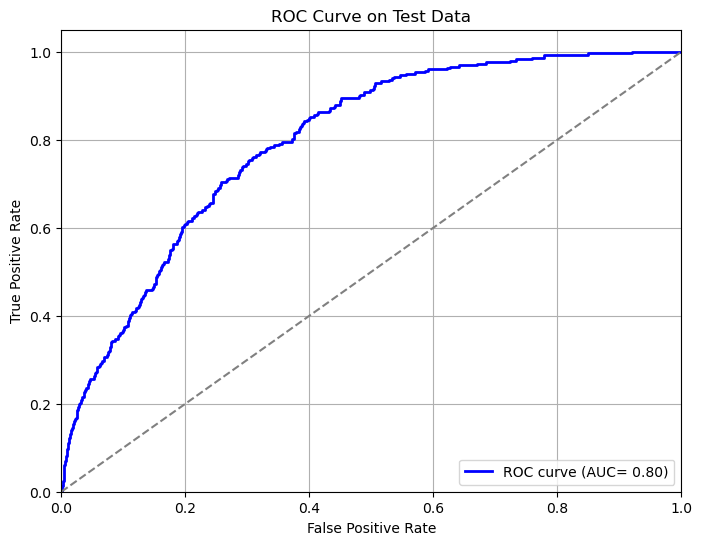

In [657]:
# ROC_AUC Curve on Test data from Train test Split 

# Compute probability of the positive class
y_prob_new = model_lr_new.predict_proba(X_test1)[:,1]
# Compute ROC curve 
fpr, tpr, thresholds = roc_curve (y_test1, y_prob_new)

# AUC_score 
roc_auc_new= roc_auc_score(y_test1,y_prob_new)
print(roc_auc_new)


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2,label = f'ROC curve (AUC= {roc_auc_new:.2f})')
plt.plot([0,1],[0,1], color = 'gray', linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curve on Test Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc ='lower right')
plt.savefig('ROC_Curve_Test_Data')
plt.grid(True)

In [658]:
# Model performance on Validation Dataset 
X_validation_new = Validation_data_finalnew.drop(columns=['bad_flag','Gender_Male','Race_White','collateral_dlrinput_newused_1req_USED'])
X_validation_new.shape

(5336, 38)

In [659]:
# Target Variable 
y_val_new = Validation_data_finalnew['bad_flag'].astype(int)
y_val_new.shape

(5336,)

In [660]:
# Print the classification report on the validation set for Logistic Regression 

0.7856009500725208
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5094
           1       0.00      0.00      0.00       242

    accuracy                           0.95      5336
   macro avg       0.48      0.50      0.49      5336
weighted avg       0.91      0.95      0.93      5336

Confusion_Matrix_LogisticReg:
 [[5094    0]
 [ 242    0]]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


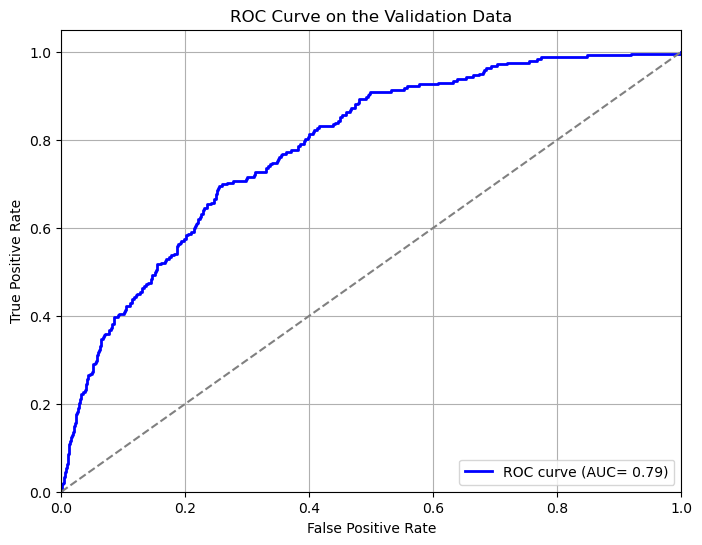

In [679]:
# 2B. ROC_AUC Curve on the Validation dataset and Logistic regression model

# Compute probability of the positive class
y_val_probn = model_lr_new.predict_proba(X_validation_new)[:,1]
y_pred_val = (y_val_probn >= 0.5).astype(int)

# Compute ROC curve 
fpr, tpr, thresholds = roc_curve (y_val_new, y_val_prob)

# AUC_score 
roc_auc_val= roc_auc_score(y_val_new,y_val_probn)
print(roc_auc_val)

# Classification Report 
print (classification_report(y_val_new, y_pred_val))

# Confusion_Matrix
#print (confusion_matrix(y_val_new, y_val_probn))
#print("ROC AUC Score:", roc_auc_score(y_val_new, y_pred_proba_valn))
#print("Classification Report:\n", classification_report(y_val_new, xgb_pred_valn))
print("Confusion_Matrix_LogisticReg:\n", confusion_matrix(y_val_new, y_pred_val))


plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2,label = f'ROC curve (AUC= {roc_auc_val:.2f})')
plt.plot([0,1],[0,1], color = 'gray', linestyle ='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.title('ROC Curve on the Validation Data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc ='lower right')
plt.savefig('ROC_Curve_Validation_Data')
plt.grid(True)

In [ ]:
# Logistic regression on Clean dataset + SMOTE 


# 3A. XGboost on the clean dataset/No Outliers /StratifiedKFold /SMOTE +Class weights

In [662]:

stratified_kfold =StratifiedKFold( n_splits =5, shuffle= True, random_state=42)

from imblearn.over_sampling import SMOTE 

# SMOTE on training set 
smote = SMOTE(sampling_strategy='auto', random_state =45)
X_train_smnew, y_train_smnew =smote.fit_resample(X_train1, y_train1)

# Set class weights to deal with imbalanced datasets 
class_weightsnew = {0: 1, 1: 10}  # Class 0: 1, Class 1: 10

# Set "scale_pos_weight" based on class balance
pos_weightnew = sum(class_weightsnew.values()) / sum(class_weightsnew.keys())

# Train XGBoost model
xgbmodel3A = xgb.XGBClassifier(scale_pos_weight=pos_weightnew)

param_gridn = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0,0.1,0.2] # Regularization Parameter
}


grid_search3A = GridSearchCV(estimator=xgbmodel3A, param_grid=param_gridn, scoring='roc_auc', cv=stratified_kfold, verbose=2, n_jobs=-1)
grid_search3A.fit(X_train1, y_train1)

# Train the best model
best_model3A = grid_search3A.best_estimator_

# Make predictions and evaluate the model
xgb_pred3A = best_model3A.predict(X_test1)
y_pred_proba3A = best_model3A.predict_proba(X_test1)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy3A = accuracy_score(y_test1, xgb_pred3A) # Accuracy is calculated based on comapring predictions and actual y_test values 

print("Best Parameters:", grid_search3A.best_params_)
print("ROC AUC Score:", roc_auc_score(y_test1, y_pred_proba3A))
print("Classification Report:\n", classification_report(y_test1, xgb_pred3A))
print("Confusion Matrix:\n", confusion_matrix(y_test1, xgb_pred3A))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
ROC AUC Score: 0.8093916802081718
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      6185
           1       0.15      0.45      0.23       297

    accuracy                           0.86      6482
   macro avg       0.56      0.66      0.58      6482
weighted avg       0.93      0.86      0.89      6482

Confusion Matrix:
 [[5446  739]
 [ 164  133]]


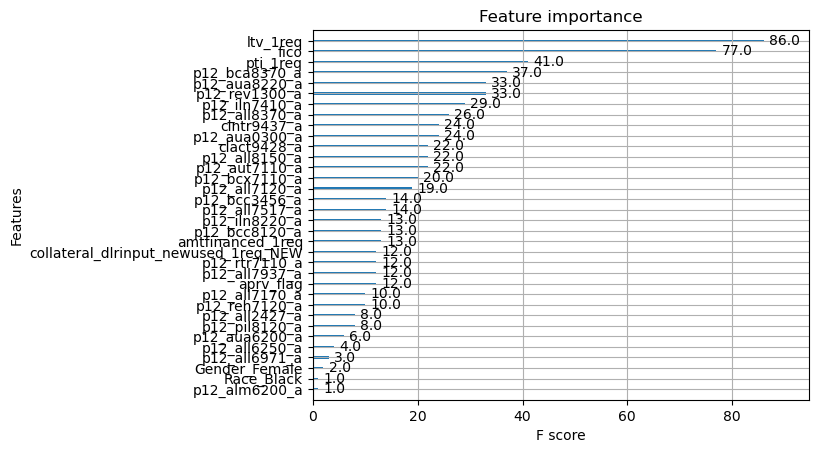

In [663]:
# Feature Importance Plot 
xgb.plot_importance(best_model3A, importance_type= 'weight')
plt.savefig('Feature_Importance_Plot')
plt.show()

In [ ]:
# Insights from feature importance plot 
# Both race and gender occupy lower position in the plot indicating that they arent prominent in deciding the application for loan 

In [680]:
#  Performance metrics on the Validation dataset/ StratifiedKFold XGBoost

# Make predictions and evaluate the model
xgb_pred_valn = best_model3A.predict(X_validation_new)
y_pred_proba_valn = best_model3A.predict_proba(X_validation_new)[:, 1] # Predicted Probability is required for the ROC_AUC score 

# Evaluate accuracy
accuracy_valn = accuracy_score(y_val_new, xgb_pred_valn) # Accuracy is calculated based on comparing predictions and actual y_val values 
print(accuracy_valn)
print("ROC AUC Score:", roc_auc_score(y_val_new, y_pred_proba_valn))
print("Classification Report:\n", classification_report(y_val_new, xgb_pred_valn))
print("Confusion_Matrix_XGBoost:\n", confusion_matrix(y_val_new, xgb_pred_valn))

0.8993628185907047
ROC AUC Score: 0.7960669982835097
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      5094
           1       0.18      0.33      0.23       242

    accuracy                           0.90      5336
   macro avg       0.57      0.63      0.59      5336
weighted avg       0.93      0.90      0.91      5336

Confusion_Matrix_XGBoost:
 [[4718  376]
 [ 161   81]]


In [ ]:
# Insights from above Model Performance on the Validation Data 
# 1. f1- score imporved for the class -0
# 2. Precision is higher for the class 1 
# 3. # Both False Positive and False Negative decreased 

In [678]:
# Features Analysis for 'Race' : White Vs Non_white/ Performance on the validation data  
# Calculation of Disparate Impact (DI) 

# boolean filter for Non-White rows
non_white_race= X_validation_new[['Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other']].sum(axis=1) > 0

# Positive prediction rate (Non-White)
non_white_rate = np.mean(best_model3A.predict(X_validation_new[non_white_race]) == 1)

# boolean filter for White rows
white_race = ~non_white_race

# White positive prediction rate 
white_rate = np.mean(best_model3A.predict(X_validation_new[white_race]) == 1)

# DI (White vs. Non-White)
disparate_impact = white_rate / non_white_rate

print("White Positive Prediction Rate:", white_rate.round(3))
print("Non-White Positive Prediction Rate:", non_white_rate.round(3))
print("Disparate Impact (White vs. Non-White):", disparate_impact.round(3))

White Positive Prediction Rate: 0.078
Non-White Positive Prediction Rate: 0.094
Disparate Impact (White vs. Non-White): 0.832


In [ ]:
# Insights : As the disparate impact > 0.8 : There is no bias. ( Cite one paper) 

In [533]:
X_validation_new.head()

fico  aprv_flag  amtfinanced_1req  pti_1req  ltv_1req  \
0 -2.652055e-01          1          0.079733 -1.000153 -0.429812   
1 -9.371774e-01          0         -0.769376 -1.313359 -0.612421   
2  8.954731e-01          1          1.413865 -1.201336  0.285783   
3  2.235013e-01          1          1.339013 -1.235629 -0.096977   
4 -1.388988e-15          0         -1.035569 -0.268576  0.449052   

   p12_reh7120_a  p12_bcx7110_a  p12_all7170_a  p12_aut7110_a  p12_all7120_a  \
0   9.607581e-01       1.143051       -0.25604       0.000000      -0.000293   
1  -2.008471e-16       0.000000       -0.25604       0.000000      -0.000293   
2  -8.200455e-01      -0.574854       -0.25604       0.000000       0.232730   
3   1.186892e+00       1.572528       -0.25604      -0.297339       0.206838   
4  -2.547110e-01      -0.508781       -0.25604       0.000000      -1.113627   

   ...  p12_all6971_a  clntr9437_a  clact9428_a  \
0  ...      -0.435756          0.0     0.000000   
1  ...      -0.435756          0.0    -0.385261   
2  ...      -0.435756          0.0     0.000000   
3  ...      -0.435756          0.0     0.000000   
4  ...      -0.435756          0.0     0.000000   

   collateral_dlrinput_newused_1req_NEW  Gender_Female  Gender_Undefined  \
0                                     0              0                 1   
1                                     0              1                 0   
2                                     1              1                 0   
3                                     1              0                 0   
4                                     0              1                 0   

   Race_Asian  Race_Black  Race_Hispanic  Race_Other  
0           0           0              0           0  
1           0           0              0           0  
2           0           0              1           0  
3           0           0              0           0  
4           0           0              0           0  

[5 rows x 38 columns]

In [535]:
X_validation_new.columns

Index(['fico', 'aprv_flag', 'amtfinanced_1req', 'pti_1req', 'ltv_1req',
       'p12_reh7120_a', 'p12_bcx7110_a', 'p12_all7170_a', 'p12_aut7110_a',
       'p12_all7120_a', 'p12_all7937_a', 'p12_bcc8120_a', 'p12_iln7410_a',
       'p12_rev1300_a', 'p12_all8150_a', 'p12_bca8370_a', 'p12_all7517_a',
       'p12_iln8220_a', 'p12_all6250_a', 'p12_rtr7110_a', 'p12_pil8120_a',
       'p12_aua0300_a', 'p12_bcc3456_a', 'p12_all8370_a', 'p12_aua8220_a',
       'p12_aua6200_a', 'p12_all2427_a', 'p12_alm6200_a', 'p12_all6971_a',
       'clntr9437_a', 'clact9428_a', 'collateral_dlrinput_newused_1req_NEW',
       'Gender_Female', 'Gender_Undefined', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other'],
      dtype='object')

In [537]:
# Feature Ananlysis of the gender data ( If feamle have a lower approval rate in the model) \

# Filter the male and female data
female= X_validation_new[X_validation_new['Gender_Female']==1]
male= X_validation_new[X_validation_new['Gender_Female']==0]


# y_true Values for female and male
y_true_f = y_val_new[X_validation_new['Gender_Female']==1]
y_true_m = y_val_new[X_validation_new['Gender_Female']==0]

# Predict the response for both female and male (bad_flag : Proportion of bad_flag=0)
y_pred_f = best_model3A.predict(female)
y_pred_m = best_model3A.predict(male)

# Calculate approval rate 
female_appro_rate = np.mean(y_pred_f == 0)
male_appro_rate = np.mean(y_pred_m == 0)

print("Female Approval Rate:",female_appro_rate) 
print("Male Approval Rate:",male_appro_rate) 



Female Approval Rate: 0.915700267618198
Male Approval Rate: 0.9127343244990304


In [ ]:
# Female approval rate is higher than makle approval rate. Hence the model is not biased against the female 
# Approval Rate for Female Customers: The percentage of female customers predicted to have good loan performance in last 12 months (bad_flag = 0).

# SHAP Analysis for feature Importance 

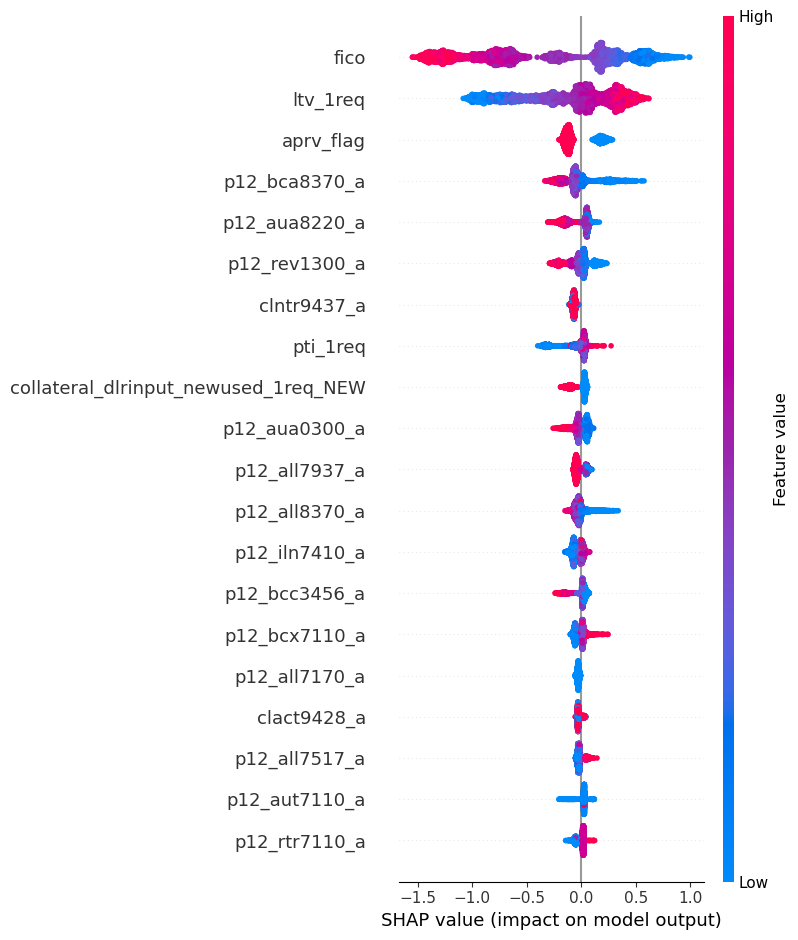

<Figure size 640x480 with 0 Axes>

In [553]:
# SHAP
import shap
explainer1 = shap.Explainer(best_model3A)
shap_values1 = explainer(X_validation_new)
shap.summary_plot(shap_values1, X_validation_new)
plt.savefig('Summary_Plot_Shap_Values')

In [682]:
# For a specific instance 
# Visualizing SHAP values for a specific instance
shap.initjs()
plt.savefig('Force_Plot_feature_importance')
shap.force_plot(shap_values1[0], X_validation_new.iloc[0])

<Figure size 640x480 with 0 Axes>

In [ ]:
# Interpretation : 
# Feature contribution is represented by the arrows: Right arrow pushes the prediction towards approval, left arrow pushes the prediction towards rejection 
# Base value is the average predcition value of the model (In the loan approval process : this is the probability of the outcome based on training data)
# Length and Direction of arrow : magnitude of feature's contribution 
# Colour : Blue - lower values, Red - higher values:  represents the feature importance 
